In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import os
import pandas as pd
from pathlib import Path
from scipy import stats
import seaborn as sns

In [2]:
sns.set_theme(style="whitegrid", font_scale=1.1)

# Load Data

In [3]:
# CPI: https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1913-
cpi_map = {
    2013: 233,
    2014: 236.7,
    2015: 237,
    2016: 240,
    2017: 245.1,
    2018: 251.1,
    2019: 255.7,
    2020: 258.8,
    2021: 271,
    2022: 292.7,
    2023: 304.7,
    2024: 313.7,
    2025: 322.3
}

In [48]:
cpt_spine_unmerged = {
    "instrumentation": ["22840", "22842", "22843", "22844", "22845", "22846", "22847", "22853", "22854", "22859", "22849"],
    "bone_grafting": ["20930", "20931", "20936", "20937", "20938", "20939"],
    "decompression_add_ons": ["63048", "63035"],
    "decompression_cervical": ["63001", "63015", "63045", "63020", "63040", "63043", "63050", "63051", "63075", "63076", "63081", "63082"],
    "decompression_thoracic": ["63003", "63016", "63046", "63085", "63086", "63087"],
    "decompression_lumbar": ["63005", "63017", "63047", "63030", "63042", "63044", "63052", "63053", "62380", "63090", "63091"],
    "fusion_add_ons": ["22585", "22614", "22534"],
    "fusion_multiple_regions": ["22800", "22802", "22804", "22810", "22812"],
    "fusion_cervical": ["22551", "22552", "22554", "22590", "22595"],
    "fusion_thoracic": ["22556", "22532"],
    "fusion_lumbar": ["22558", "22533", "22612", "22630", "22632", "22633", "22634"],
}

cpt_spine = {
    "instrumentation": ["22840", "22842", "22843", "22844", "22845", "22846", "22847", "22853", "22854", "22859", "22849"],
    "bone_grafting": ["20930", "20931", "20936", "20937", "20938", "20939"],
    "decompression": [
        "63001", "63015", "63045", "63020", "63040", "63043", # "63048", "63035", 
        "63050", "63051", "63075", "63076", "63081", "63082", "63003", "63016",
        "63046", "63085", "63086", "63087", "63005", "63017", "63047", "63030",
        "63042", "63044", "63052", "63053", "62380", "63090", "63091"
    ],
    "fusion": [
        "22800", "22802", "22804", "22810", "22812", # "22585", "22614", "22534", 
        "22551", "22552", "22554", "22590", "22595", "22556", "22532", "22558",
        "22533", "22612", "22630", "22632", "22633", "22634"
    ],
}

cpt_neurovasc = {
    'aneurysm_coiling_embo': ['61624', '61626'],
    'embo_dr': ['75894', '75898'],
    'thrombectomy': ['61645'],
    'intracranial_stent_angioplasty': ['61630', '61635', '61640', '61641', '61642'],
    'intraarterial_pharm_infusion': ['61650', '61651'],
    'temp_balloon': ['61623'],
    'cerebral_angio': ['36221', '36222', '36223', '36224', '36225', '36226', '36227', '36228']
}

cpt_map = {}

for category, codes in {**cpt_spine, **cpt_neurovasc}.items():
    for code in codes:
        cpt_map[int(code)] = category

In [49]:
current_dir = os.getcwd()

In [50]:
spine_data = pd.read_csv(os.path.join(current_dir, "processed-data", "spine_cpt_processed.csv"))
neurovasc_data = pd.read_csv(os.path.join(current_dir, "processed-data", "neurovasc_cpt_processed.csv"))

# Analysis

In [51]:
for df in [spine_data, neurovasc_data]:
    df['CPI'] = df['year'].map(cpi_map).fillna(0)
    
    # Adjusted amounts
    df['Avg_Mdcr_Stdzd_Amt_adj'] = df['Avg_Mdcr_Stdzd_Amt'] / df['CPI'] * cpi_map[2023]
    df['Avg_Mdcr_Pymt_Amt_adj'] = df['Avg_Mdcr_Pymt_Amt'] / df['CPI'] * cpi_map[2023]

    # Raw amounts summed over services per provider
    df['Tot_Srvcs_Spend'] = df['Tot_Srvcs'] * df['Avg_Mdcr_Stdzd_Amt'] 
    df['Tot_Pymt'] = df['Tot_Srvcs'] * df['Avg_Mdcr_Pymt_Amt'] 

    # Raw amounts summed over services per provider, adjusted
    df['Tot_Srvcs_Spend_adj'] = df['Tot_Srvcs'] * df['Avg_Mdcr_Stdzd_Amt_adj'] 
    df['Tot_Pymt_adj'] = df['Tot_Srvcs'] * df['Avg_Mdcr_Pymt_Amt_adj'] 

In [52]:
spine_data = spine_data[["HCPCS_Cd", "Rndrng_NPI", "Tot_Srvcs", "Avg_Mdcr_Stdzd_Amt", "Avg_Mdcr_Pymt_Amt", "Tot_Srvcs_Spend", "Tot_Pymt", "Avg_Mdcr_Stdzd_Amt_adj", "Avg_Mdcr_Pymt_Amt_adj", "Tot_Srvcs_Spend_adj", "Tot_Pymt_adj", "year"]]
neurovasc_data = neurovasc_data[["HCPCS_Cd", "Rndrng_NPI", "Tot_Srvcs", "Avg_Mdcr_Stdzd_Amt", "Avg_Mdcr_Pymt_Amt",  "Tot_Srvcs_Spend", "Tot_Pymt", "Avg_Mdcr_Stdzd_Amt_adj", "Avg_Mdcr_Pymt_Amt_adj", "Tot_Srvcs_Spend_adj", "Tot_Pymt_adj", "year"]]

In [53]:
for data in [spine_data, neurovasc_data]:
    data['procedure'] = data['HCPCS_Cd'].map(cpt_map)

/var/folders/jv/hvl4bxhn45d10f4fq__lhlxm0000gn/T/ipykernel_51781/2081504999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['procedure'] = data['HCPCS_Cd'].map(cpt_map)


In [54]:
groupby_key = 'procedure'
specialty_name = ["Spine", "Neurovasc"]

In [55]:
# Group by procedure and year, and summarize
util_2023_2013_adj_spine = (
    spine_data
    .groupby([groupby_key, 'year'], as_index=False)
    .agg(
        Sum_Utilization=('Tot_Srvcs', 'sum'),
        Sum_Spend=('Tot_Srvcs_Spend', 'sum'),
        Sum_Pymt=('Tot_Pymt', 'sum'),
        Sum_Spend_adj=('Tot_Srvcs_Spend_adj', 'sum'),
        Sum_Pymt_adj=('Tot_Pymt_adj', 'sum'),
        Avg_Price_per_service_adj=('Avg_Mdcr_Stdzd_Amt_adj', 'mean'),
        Avg_Price_per_service_adj_sem=('Avg_Mdcr_Stdzd_Amt_adj', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
        Tot_Pymt_adj=('Tot_Pymt_adj', 'mean'), # Tot_Pymt is actually Avg_Pymt, bad naming
        Tot_Pymt_adj_sem=('Tot_Pymt_adj', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
        Sum_Provider=('Rndrng_NPI', lambda x: x.nunique())
    )
)

util_2023_2013_adj_neurovasc = (
    neurovasc_data
    .groupby([groupby_key, 'year'], as_index=False)
    .agg(
        Sum_Utilization=('Tot_Srvcs', 'sum'),
        Sum_Spend=('Tot_Srvcs_Spend', 'sum'),
        Sum_Pymt=('Tot_Pymt', 'sum'),
        Sum_Spend_adj=('Tot_Srvcs_Spend_adj', 'sum'),
        Sum_Pymt_adj=('Tot_Pymt_adj', 'sum'),
        Avg_Price_per_service_adj=('Avg_Mdcr_Stdzd_Amt_adj', 'mean'),
        Avg_Price_per_service_adj_sem=('Avg_Mdcr_Stdzd_Amt_adj', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
        Tot_Pymt_adj=('Tot_Pymt_adj', 'mean'), # Tot_Pymt is actually Avg_Pymt, bad naming
        Tot_Pymt_adj_sem=('Tot_Pymt_adj', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
        Sum_Provider=('Rndrng_NPI', lambda x: x.nunique()))
)

## Utilization per Year

In [56]:
colors = [
    "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", 
    "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "black", "gold" 
]

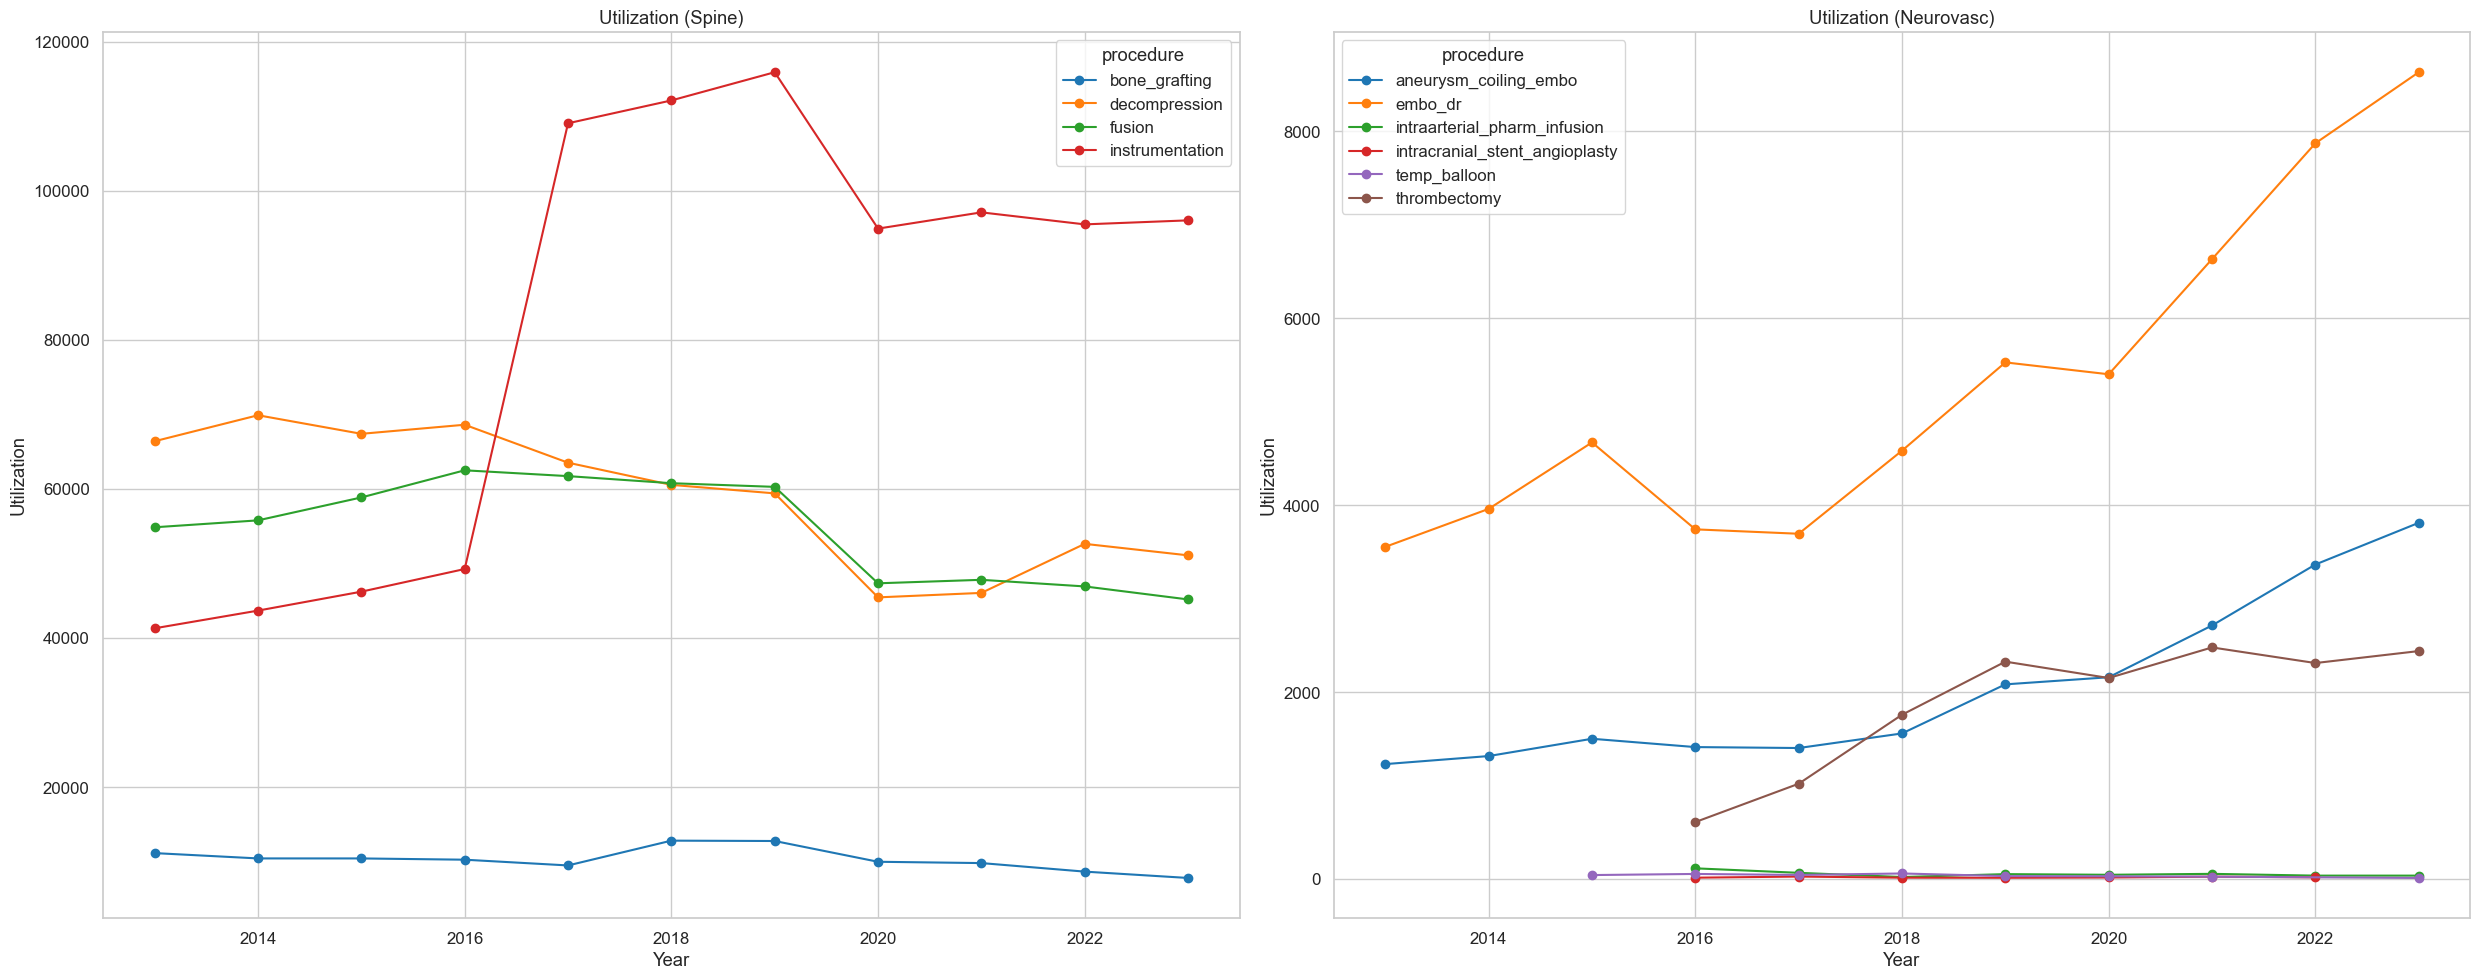

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10)) 
for i, specialty in enumerate([util_2023_2013_adj_spine, util_2023_2013_adj_neurovasc]):
    grouped = specialty.groupby(groupby_key)
    p_num = 0
    
    for label, df in grouped:
        # Sort by year to ensure proper line plotting
        df_sorted = df.sort_values('year')

        x = df_sorted['year']
        y = df_sorted['Sum_Utilization']

        axs[i].plot(x, y, label=label, marker='o', markersize=6, linestyle='-', color=colors[p_num])
        p_num += 1
    
    axs[i].legend(title=groupby_key)
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Utilization")
    axs[i].set_title(f"Utilization ({specialty_name[i]})")

plt.tight_layout()

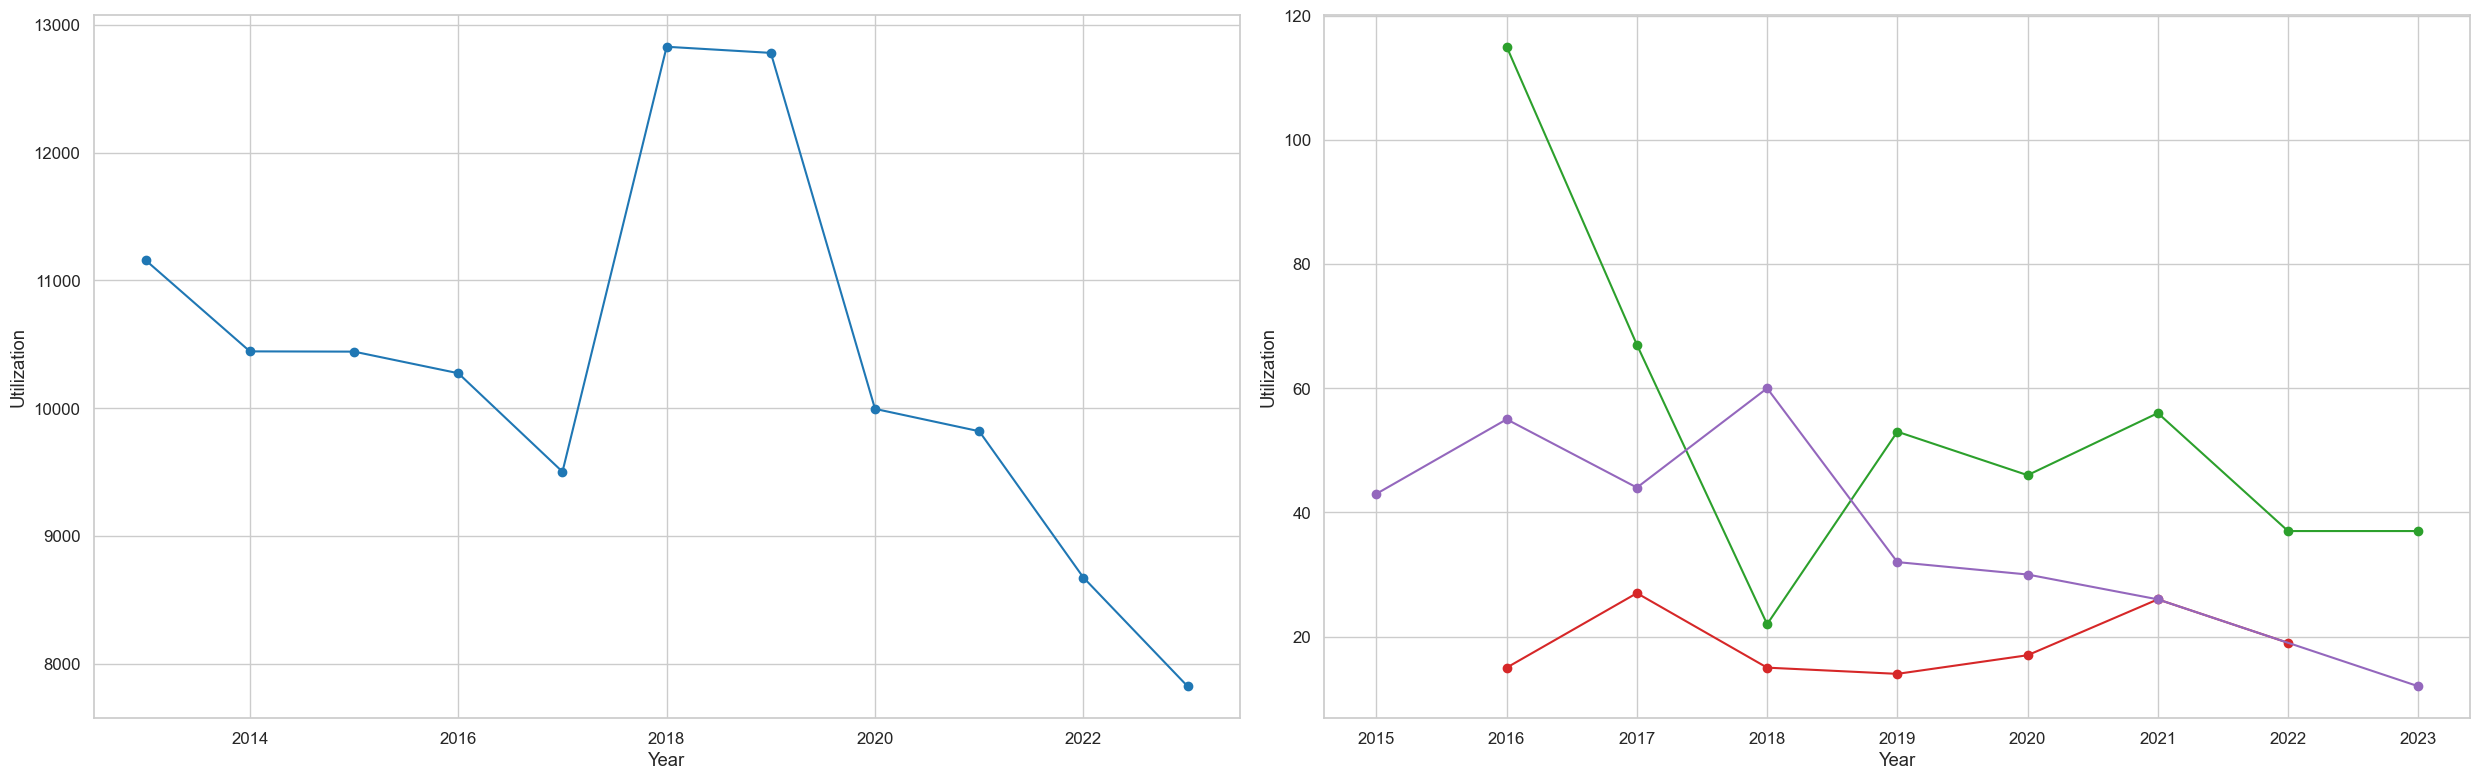

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8)) 
plot_inset = [
    ['fusion_cervical', 'bone_grafting', 'decompression_cervical', 'decompression_thoracic', 'fusion_thoracic', 'fusion_multiple_regions'],
    ["intracranial_stent_angioplasty", "intraarterial_pharm_infusion", "temp_balloon"]
]

for i, specialty in enumerate([util_2023_2013_adj_spine, util_2023_2013_adj_neurovasc]):
    grouped = specialty.groupby(groupby_key)
    p_num = 0
    
    for label, df in grouped:
        # Sort by year to ensure proper line plotting
        df_sorted = df.sort_values('year')

        x = df_sorted['year']
        y = df_sorted['Sum_Utilization']

        if label in plot_inset[i]:
            axs[i].plot(x, y, label=label, marker='o', markersize=6, linestyle='-', color=colors[p_num])

        p_num += 1
    
    # axs[i].legend(title=groupby_key)
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Utilization")
    # axs[i].set_title(f"Utilization ({specialty_name[i]})")

plt.tight_layout()

In [42]:
def add_inset(ax, rel=[0.6, 0.55, 0.35, 0.35]):
    """
    Create an inset inside `ax` without mpl_toolkits.
    rel = [left, bottom, width, height] in *axes-relative* coords (0..1).
    """
    fig = ax.figure
    bbox = ax.get_position()  # in figure coords
    left   = bbox.x0 + rel[0] * bbox.width
    bottom = bbox.y0 + rel[1] * bbox.height
    width  = rel[2] * bbox.width
    height = rel[3] * bbox.height
    return fig.add_axes([left, bottom, width, height])

/var/folders/jv/hvl4bxhn45d10f4fq__lhlxm0000gn/T/ipykernel_51781/3895152932.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


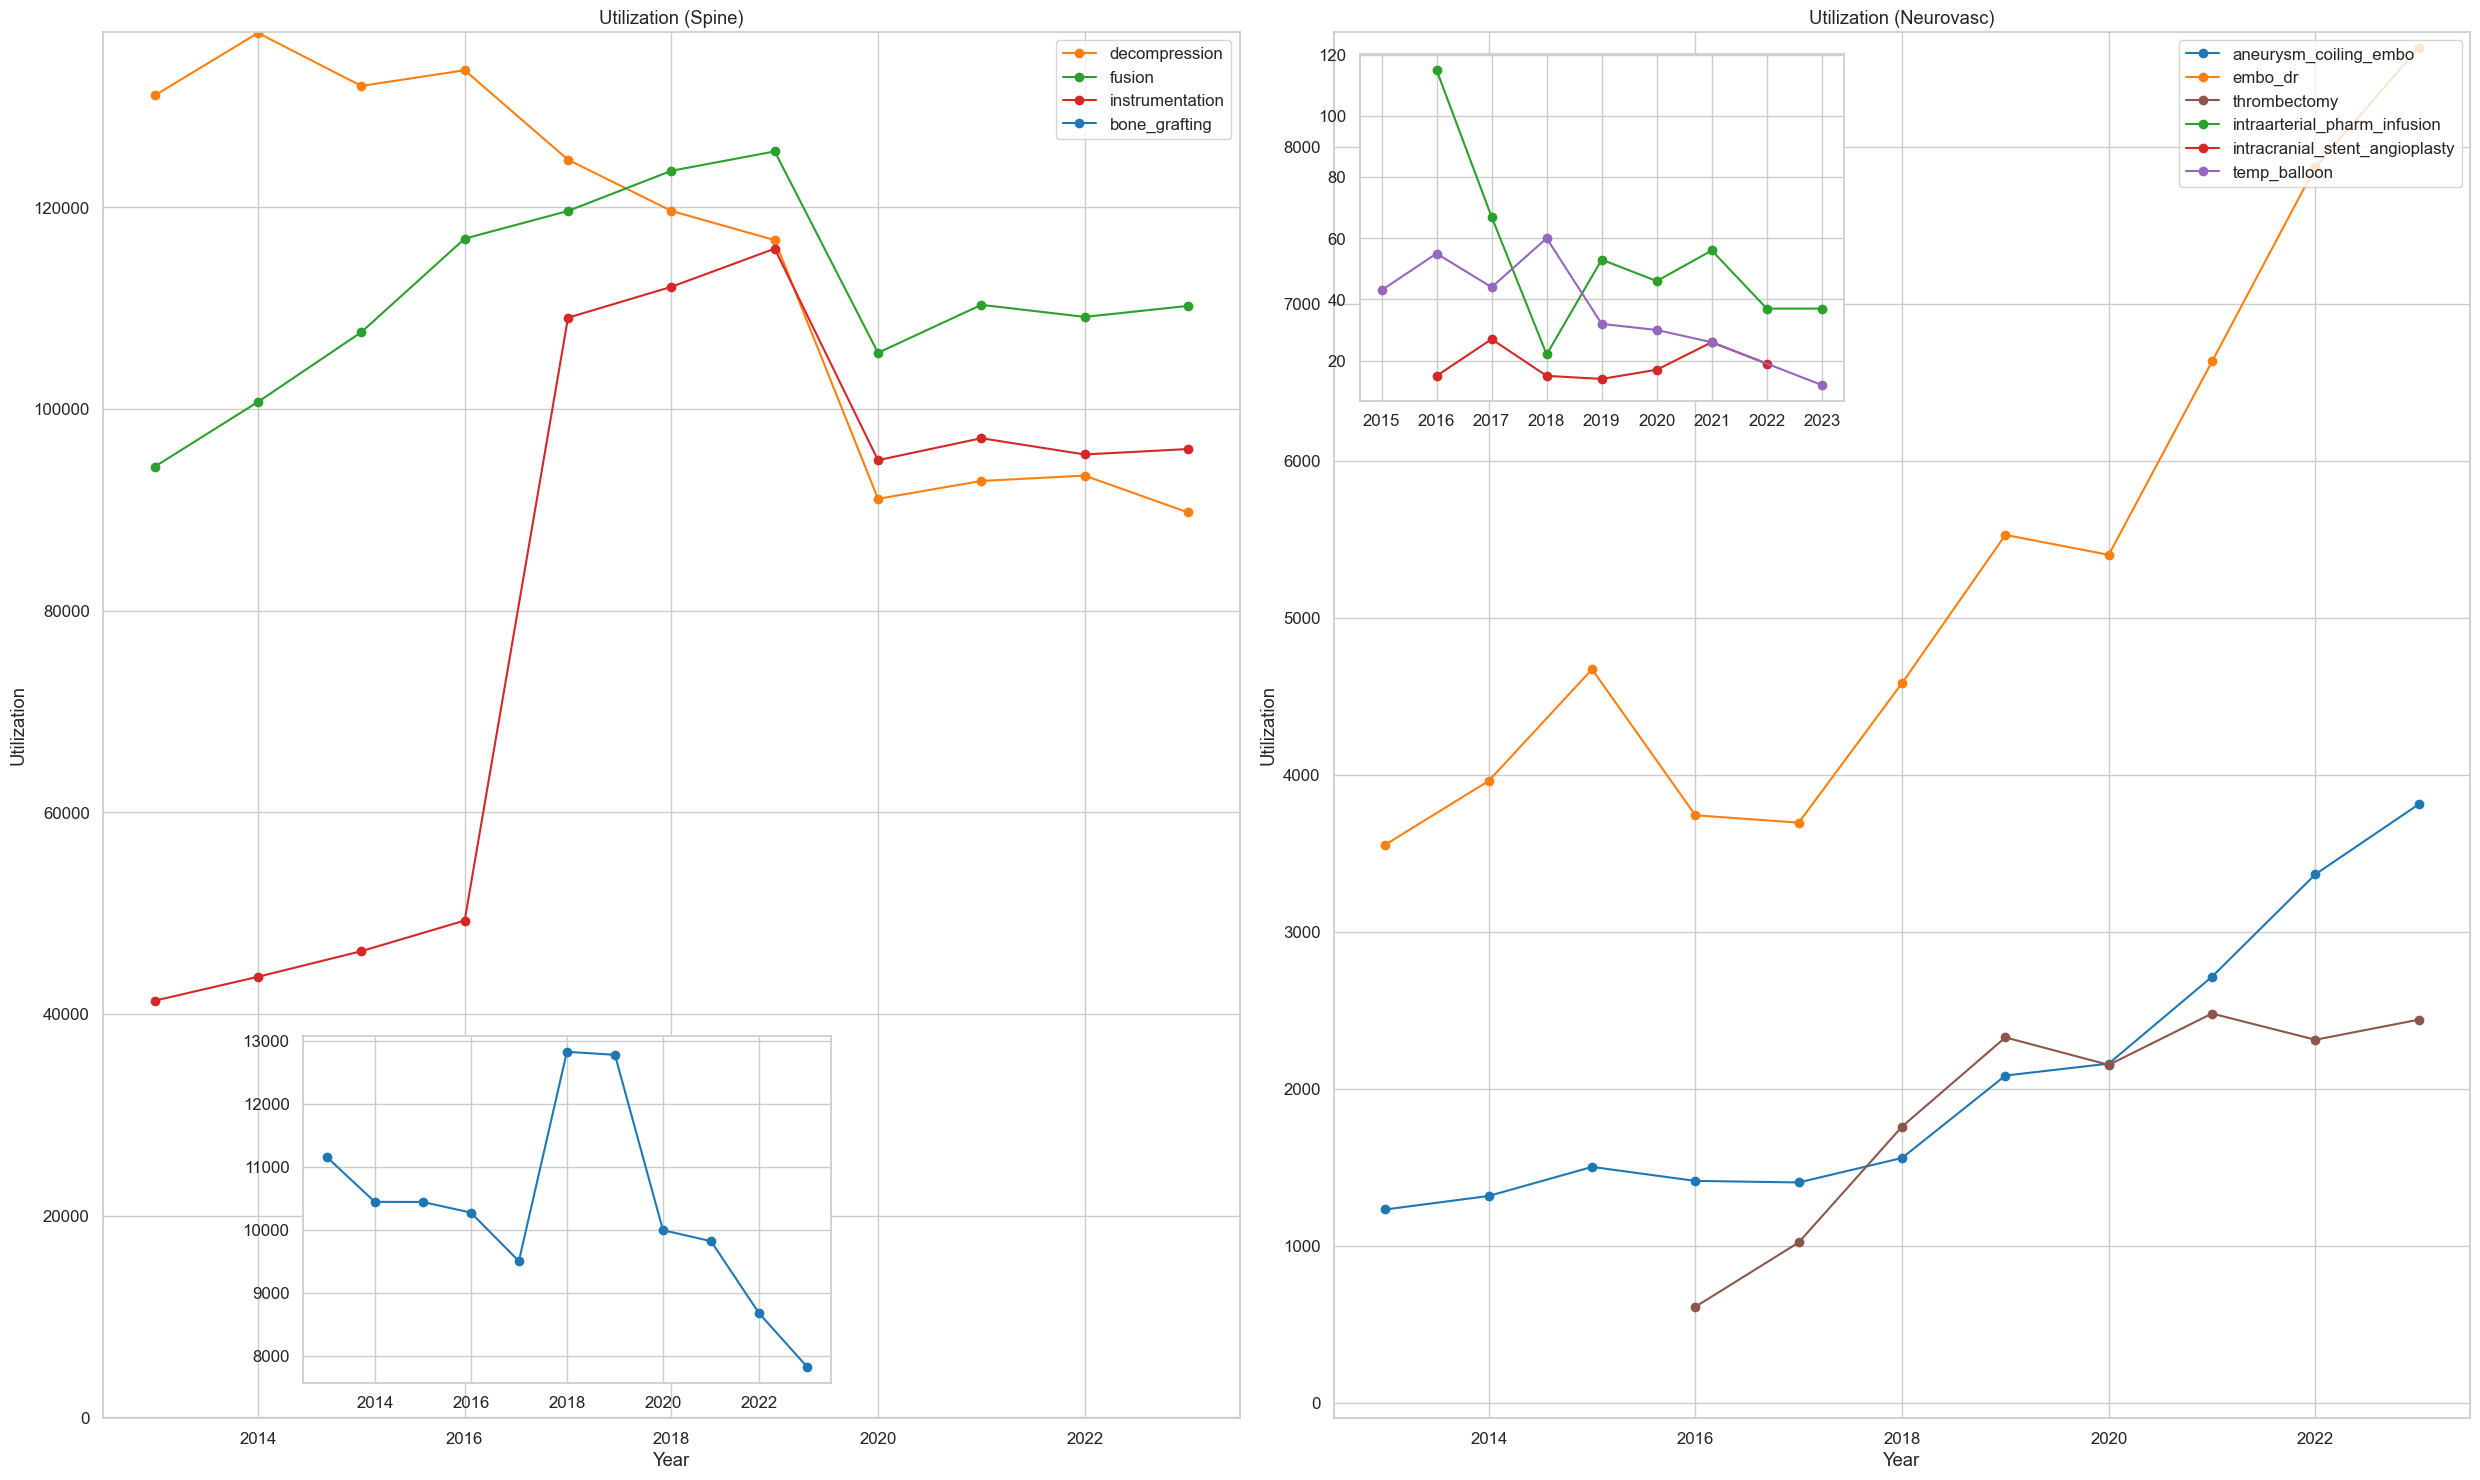

In [43]:
# with inset
fig, axs = plt.subplots(1, 2, figsize=(25, 15)) 

plot_inset = [
    ['fusion_cervical', 'bone_grafting', 'decompression_cervical', 'decompression_thoracic', 'fusion_thoracic', 'fusion_multiple_regions'],
    ["intracranial_stent_angioplasty", "intraarterial_pharm_infusion", "temp_balloon"]
]

inset_location = [[0.0, -0.05, 0.6, 0.3], [0.0, 0.8, 0.55, 0.3]]

for i, specialty in enumerate([util_2023_2013_adj_spine, util_2023_2013_adj_neurovasc]):
    grouped = specialty.groupby(groupby_key)
    axins = add_inset(axs[i], rel=inset_location[i])
    max_val = 0

    procedure_num = 0
    for label, df in grouped:
        # Sort by year to ensure proper line plotting
        df_sorted = df.sort_values('year')

        x = df_sorted['year']
        y = df_sorted['Sum_Utilization']

        max_val = max(max_val, max(y))

        if label in plot_inset[i]:
            axins.plot(x, y, label=label, marker='o', markersize=6, linestyle='-', color=colors[procedure_num])
        else:
            axs[i].plot(x, y, label=label, marker='o', markersize=6, linestyle='-', color=colors[procedure_num])

        procedure_num += 1

    # collect handles + labels from both axes
    handles_main, labels_main = axs[i].get_legend_handles_labels()
    handles_inset, labels_inset = axins.get_legend_handles_labels()
    
    # merge them
    all_handles = handles_main + handles_inset
    all_labels  = labels_main + labels_inset
    
    axs[i].legend(all_handles, all_labels, loc="upper right")

    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Utilization")
    axs[i].set_ylim([-100, max_val + 100])
    axs[i].set_title(f"Utilization ({specialty_name[i]})")

plt.tight_layout()

## Average Standardized Payment

In [65]:
util_2023_2013_adj_spine['CI_lower_avg_price_per_service'] = util_2023_2013_adj_spine['Avg_Price_per_service_adj'] - 1.96 * util_2023_2013_adj_spine['Avg_Price_per_service_adj_sem']
util_2023_2013_adj_spine['CI_upper_avg_price_per_service'] = util_2023_2013_adj_spine['Avg_Price_per_service_adj'] + 1.96 * util_2023_2013_adj_spine['Avg_Price_per_service_adj_sem']

util_2023_2013_adj_neurovasc['CI_lower_avg_price_per_service'] = util_2023_2013_adj_neurovasc['Avg_Price_per_service_adj'] - 1.96 * util_2023_2013_adj_neurovasc['Avg_Price_per_service_adj_sem']
util_2023_2013_adj_neurovasc['CI_upper_avg_price_per_service'] = util_2023_2013_adj_neurovasc['Avg_Price_per_service_adj'] + 1.96 * util_2023_2013_adj_neurovasc['Avg_Price_per_service_adj_sem']

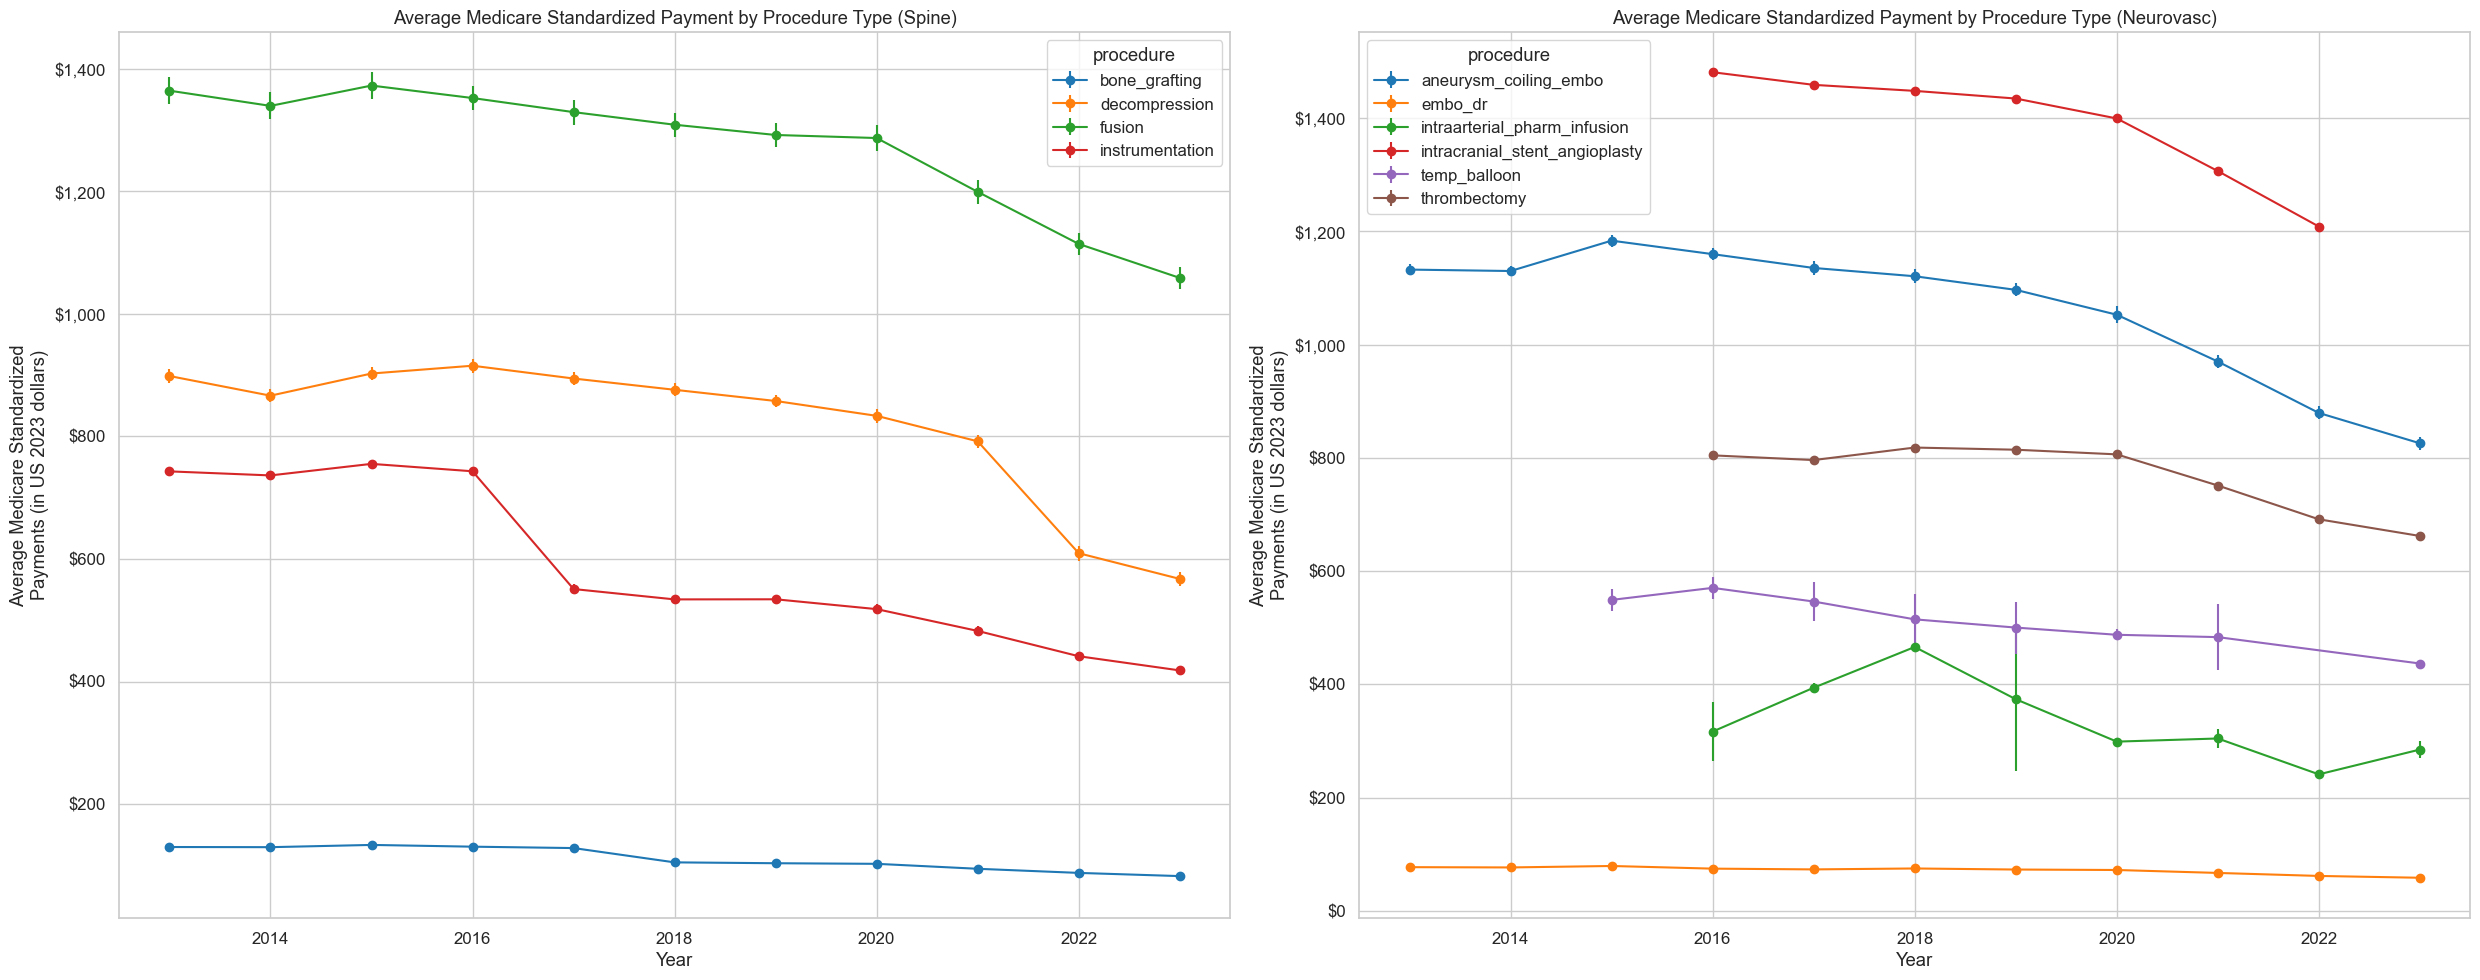

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10)) 

for i, specialty in enumerate([util_2023_2013_adj_spine, util_2023_2013_adj_neurovasc]):
    grouped = specialty.groupby(groupby_key)
    p_num = 0
    
    for label, df in grouped:
        # Sort by year to ensure proper line plotting
        df_sorted = df.sort_values('year')
        
        x = df_sorted['year']
        y = df_sorted['Avg_Price_per_service_adj']
    
        # Compute error bars from CI bounds
        yerr = [y - df_sorted['CI_lower_avg_price_per_service'], df_sorted['CI_upper_avg_price_per_service'] - y]
    
        axs[i].errorbar(x, y, yerr=yerr, label=label, marker='o', markersize=6, linestyle='-', color=colors[p_num])
        p_num += 1
    
    axs[i].legend(title=groupby_key)
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Average Medicare Standardized\nPayments (in US 2023 dollars)")
    axs[i].set_title(f"Average Medicare Standardized Payment by Procedure Type ({specialty_name[i]})")
    
    axs[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.tight_layout()

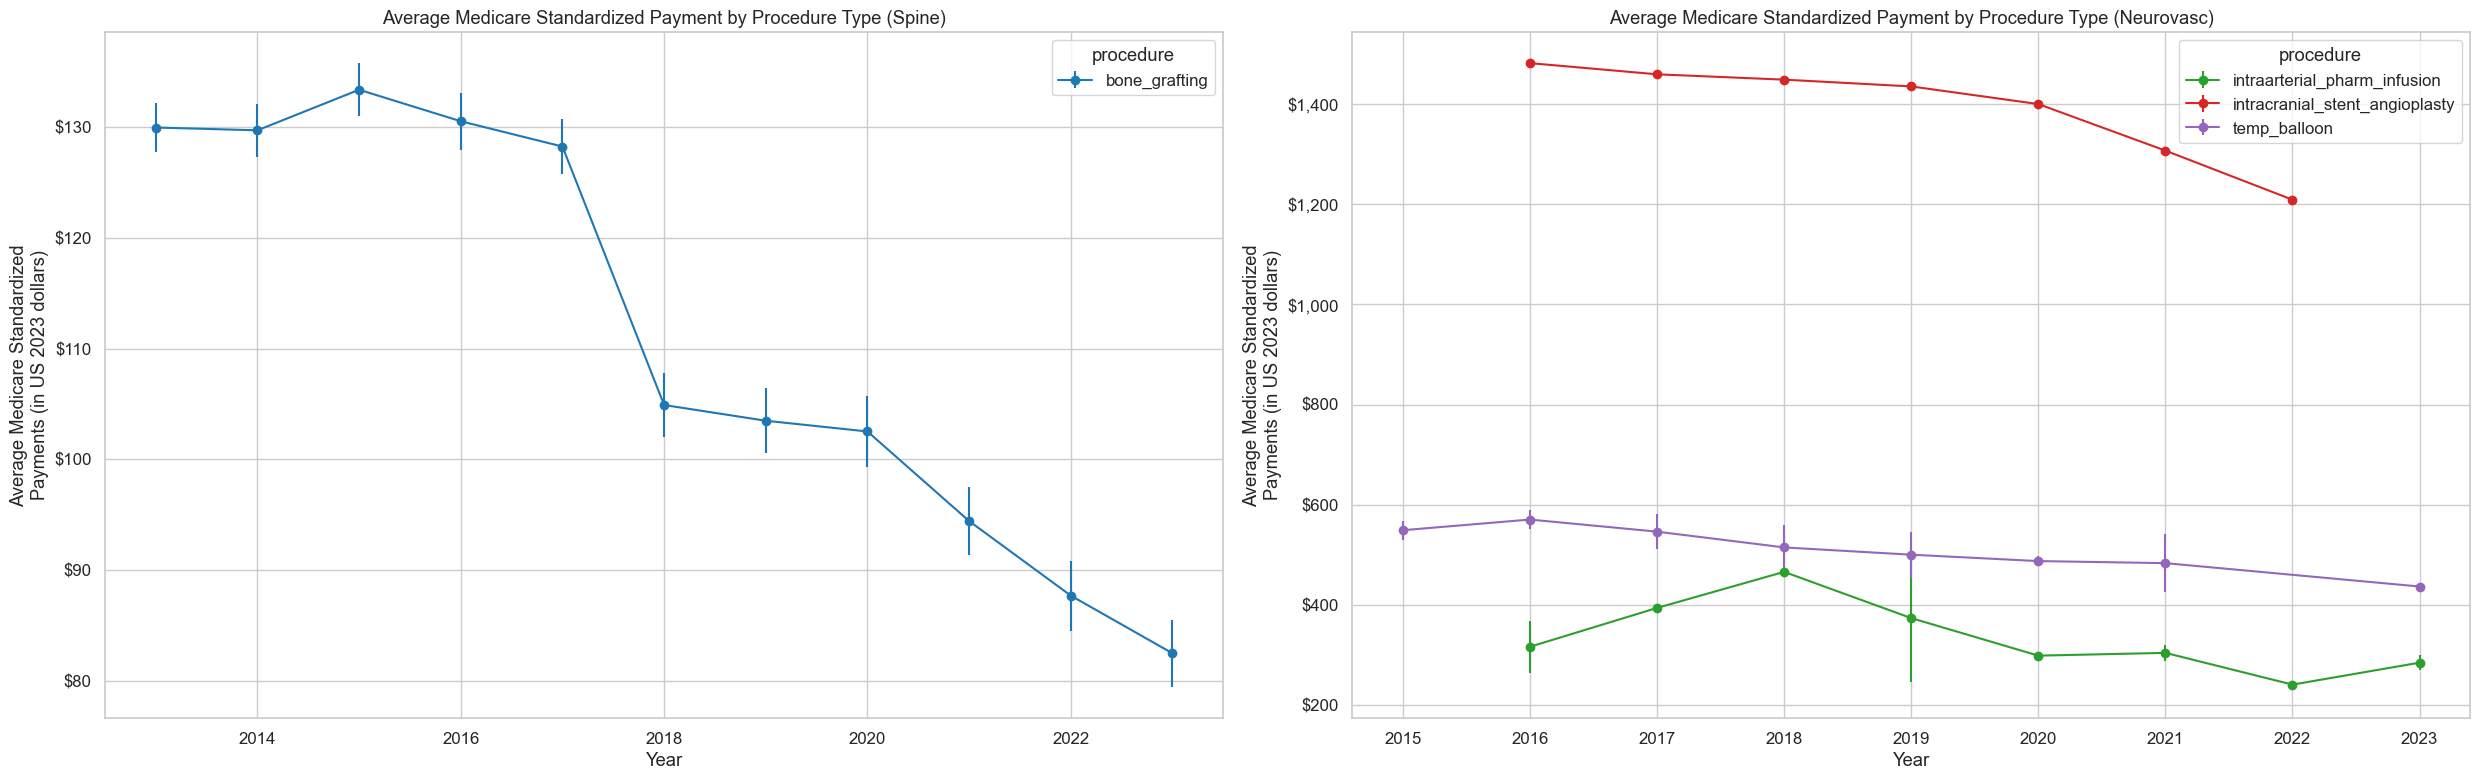

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8)) 
plot_inset = [
    ['fusion_cervical', 'bone_grafting', 'decompression_cervical', 'decompression_thoracic', 'fusion_thoracic', 'fusion_multiple_regions'],
    ["intracranial_stent_angioplasty", "intraarterial_pharm_infusion", "temp_balloon"]
]

for i, specialty in enumerate([util_2023_2013_adj_spine, util_2023_2013_adj_neurovasc]):
    grouped = specialty.groupby(groupby_key)
    p_num = 0
    
    for label, df in grouped:
        if label in plot_inset[i]:
            # Sort by year to ensure proper line plotting
            df_sorted = df.sort_values('year')
            
            x = df_sorted['year']
            y = df_sorted['Avg_Price_per_service_adj']
        
            # Compute error bars from CI bounds
            yerr = [y - df_sorted['CI_lower_avg_price_per_service'], df_sorted['CI_upper_avg_price_per_service'] - y]
    
            axs[i].errorbar(x, y, yerr=yerr, label=label, marker='o', markersize=6, linestyle='-', color=colors[p_num])
        p_num += 1
    
    axs[i].legend(title=groupby_key)
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Average Medicare Standardized\nPayments (in US 2023 dollars)")
    axs[i].set_title(f"Average Medicare Standardized Payment by Procedure Type ({specialty_name[i]})")

    axs[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.tight_layout()

## Average Standardized Payment Growth Rate

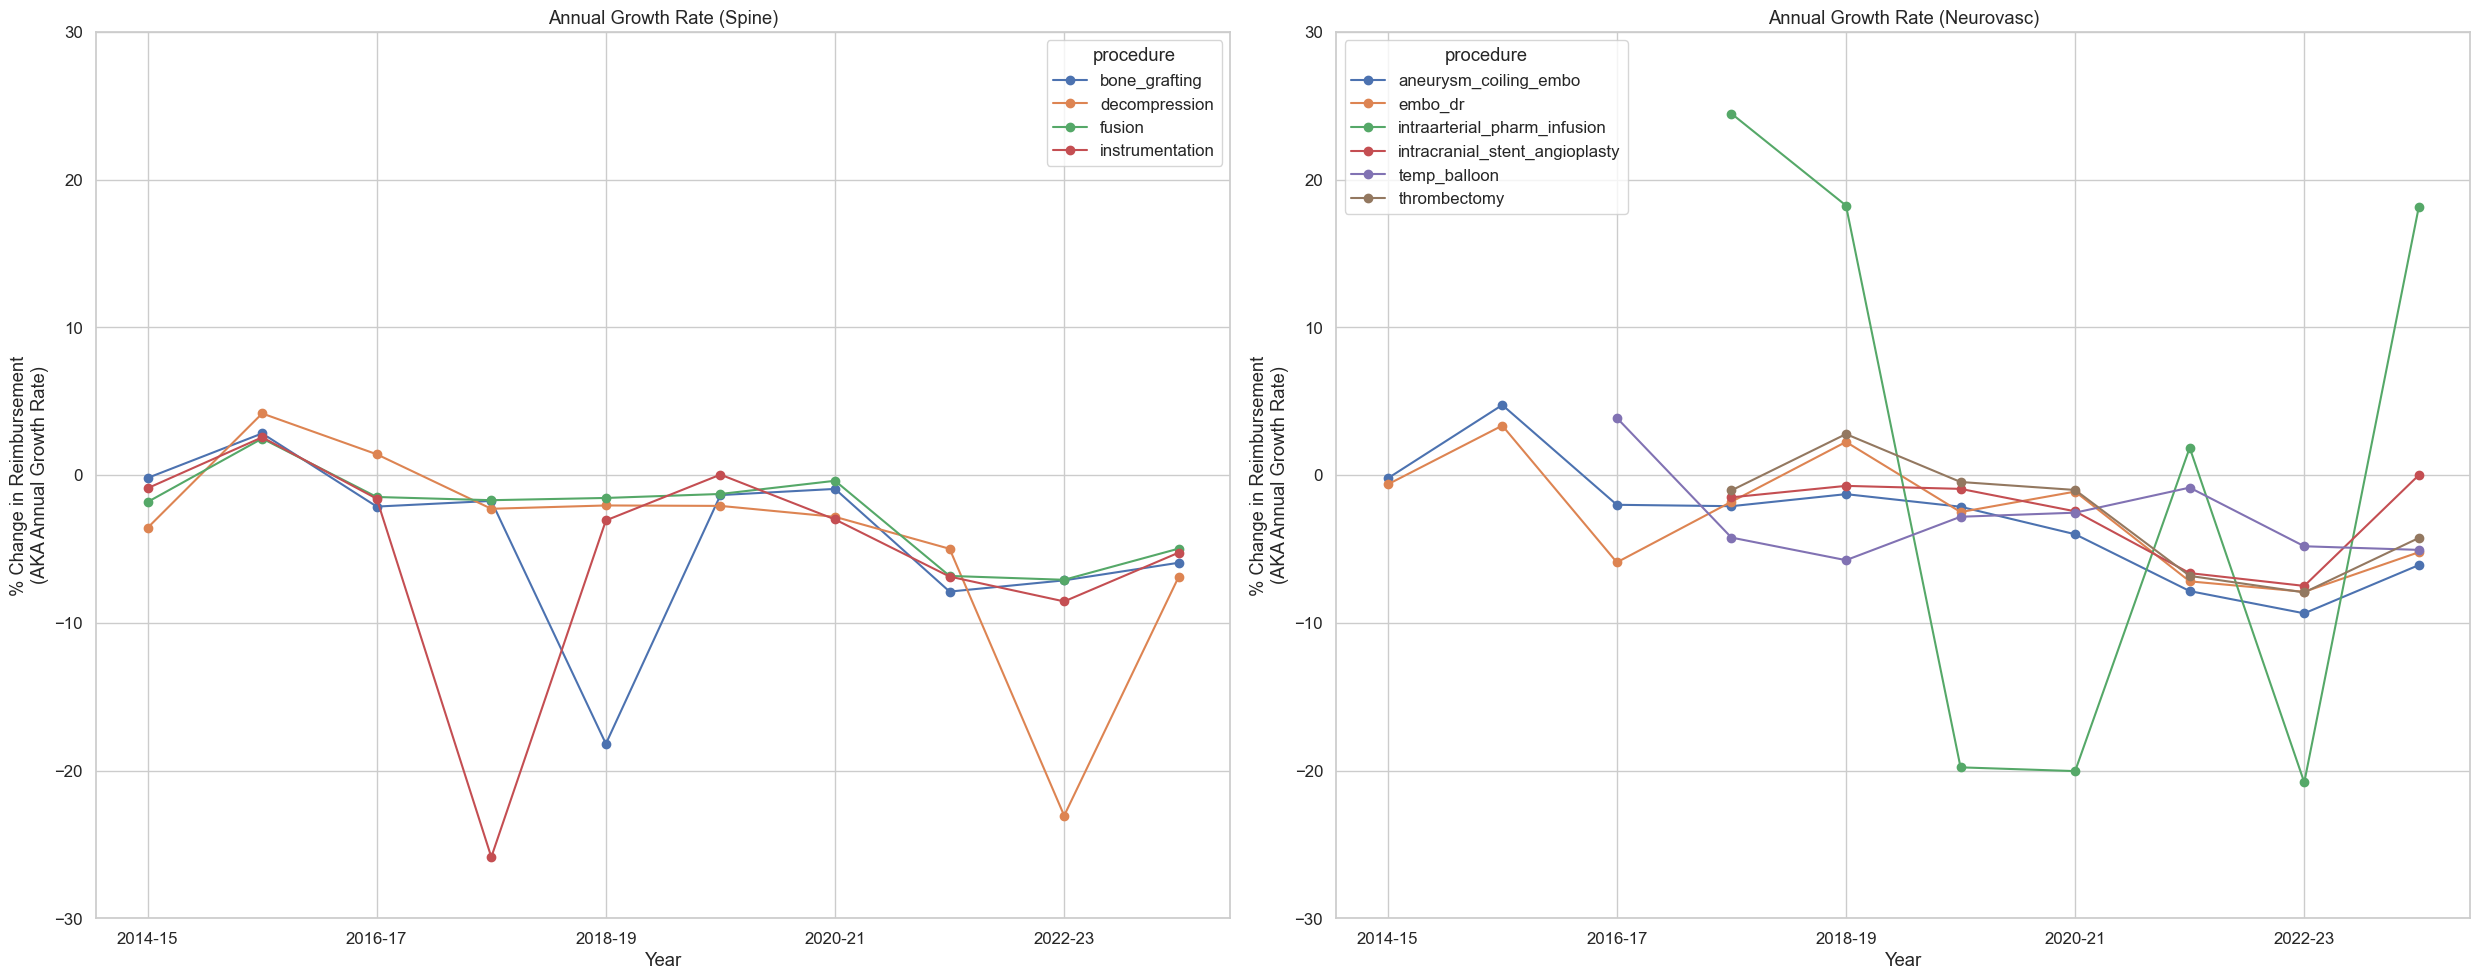

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10)) 

aagr = {'Spine': [], 'Neurovasc': []}
aagr_no_interp = {'Spine': [], 'Neurovasc': []}
all_deltas = {'Spine': [], 'Neurovasc': []}

for i, specialty in enumerate([util_2023_2013_adj_spine, util_2023_2013_adj_neurovasc]):
    grouped = specialty.groupby(groupby_key)
    for label, df in grouped:
        # Sort by year to ensure proper line plotting
        df_sorted = df.sort_values('year')
        
        x = df_sorted['year'].tolist()
        y = df_sorted['Avg_Price_per_service_adj'].tolist()
    
        pairs = {x[i]: item for i, item in enumerate(y)}
    
        x_new = list(range(2013, 2024))
    
        y_new = [pairs[year] if year in pairs else np.nan for year in x_new]
        delta = pd.Series(y_new).interpolate().pct_change().to_numpy() * 100

        axs[i].plot(range(len(delta)), delta, label=label, marker='o', markersize=6, linestyle='-')

        # Use this to compute AAGR per procedure later
        aagr[specialty_name[i]].append([label, np.nanmean(delta)])

        # Compute a version of AAGR without interpolation
        delta_no_interp = pd.Series(y_new).pct_change().to_numpy() * 100
        aagr_no_interp[specialty_name[i]].append([label, np.nanmean(delta_no_interp)])

        # Use this to plot average growth rate across procedures later
        all_deltas[specialty_name[i]].append(delta)

    axs[i].legend(title=groupby_key)
    axs[i].set_xlabel("Year")
    axs[i].set_xticks([1, 3, 5, 7, 9])
    axs[i].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
    axs[i].set_ylabel("% Change in Reimbursement\n(AKA Annual Growth Rate)")
    axs[i].set_ylim([-30, 30])
    axs[i].set_title(f"Annual Growth Rate ({specialty_name[i]})")

plt.tight_layout()

In [28]:
pd.DataFrame(aagr['Spine'] + aagr['Neurovasc'], columns=['procedure', 'AAGR (%)']).sort_values(by=['AAGR (%)'])

,procedure,AAGR (%)
3,instrumentation,-5.249871
0,bone_grafting,-4.267703
1,decompression,-3.578974
2,fusion,-3.329114
4,aneurysm_coiling_embo,-3.033358
7,intracranial_stent_angioplasty,-2.822756
8,temp_balloon,-2.776269
9,thrombectomy,-2.679421
5,embo_dr,-2.668189
6,intraarterial_pharm_infusion,0.301037


In [70]:
stats.ttest_ind([x[1] for x in aagr['Spine']], [x[1] for x in aagr['Neurovasc']], alternative='less')

Ttest_indResult(statistic=-2.227382432218495, pvalue=0.028263674596364263)

/var/folders/jv/hvl4bxhn45d10f4fq__lhlxm0000gn/T/ipykernel_51781/3708505356.py:5: RuntimeWarning: Mean of empty slice
  aagr = np.nanmean(np.array(specialty), axis=0)


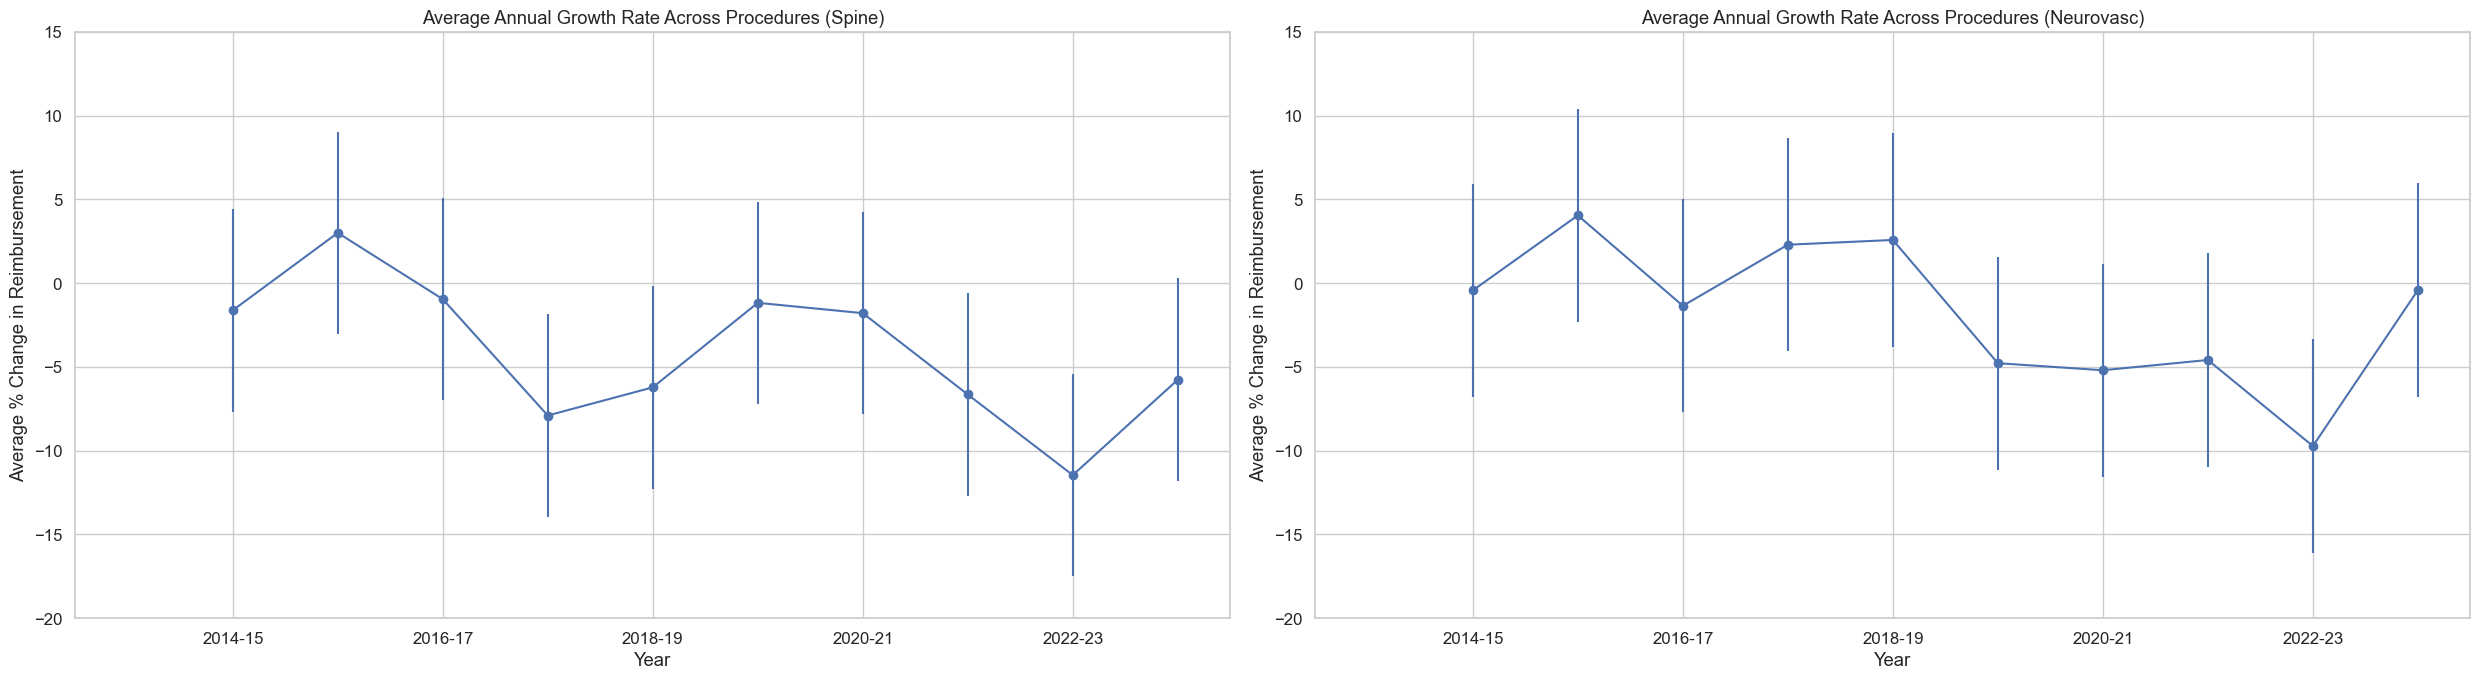

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7)) 

i = 0
for key, specialty in all_deltas.items():
    aagr = np.nanmean(np.array(specialty), axis=0)
    sem = np.nanstd(np.array(specialty), ddof=1) / np.sqrt(len(specialty))
    
    ci_lower = aagr - 1.96 * sem
    ci_upper = aagr + 1.96 * sem
    
    # Compute error bars from CI bounds
    yerr = [aagr - ci_lower, ci_upper - aagr]

    axs[i].errorbar(range(len(aagr)), aagr, yerr=yerr,  marker='o', markersize=6, linestyle='-')

    axs[i].set_xlabel("Year")
    axs[i].set_xticks([1, 3, 5, 7, 9])
    axs[i].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
    axs[i].set_ylabel("Average % Change in Reimbursement")
    axs[i].set_ylim([-20, 15])
    axs[i].set_title(f"Average Annual Growth Rate Across Procedures ({specialty_name[i]})")

    i += 1

plt.tight_layout()

## Average Standardized Payment $ Growth

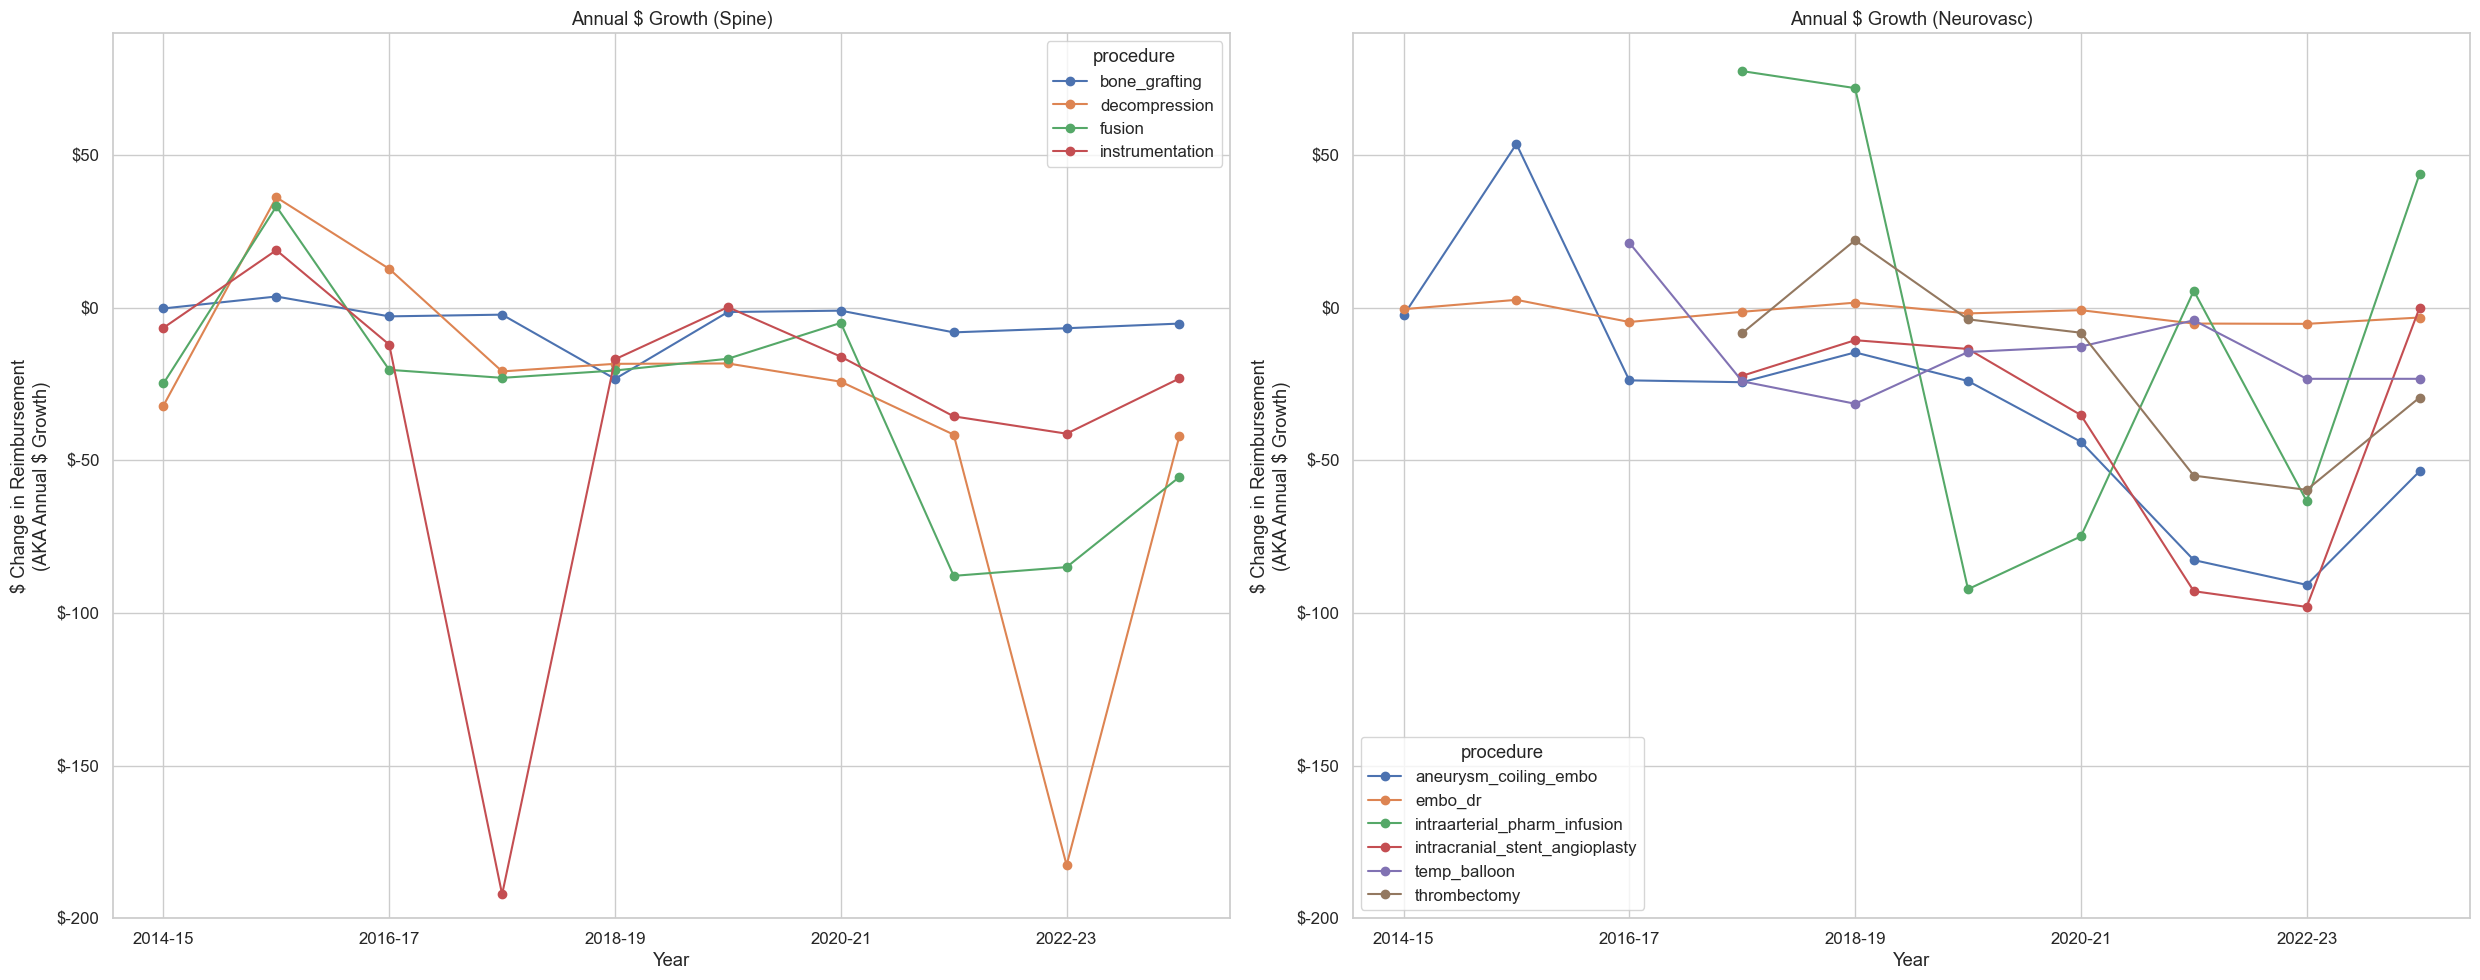

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10)) 

aagr = {'Spine': [], 'Neurovasc': []}
aagr_no_interp = {'Spine': [], 'Neurovasc': []}
all_deltas = {'Spine': [], 'Neurovasc': []}

for i, specialty in enumerate([util_2023_2013_adj_spine, util_2023_2013_adj_neurovasc]):
    grouped = specialty.groupby(groupby_key)
    for label, df in grouped:
        # Sort by year to ensure proper line plotting
        df_sorted = df.sort_values('year')
        
        x = df_sorted['year'].tolist()
        y = df_sorted['Avg_Price_per_service_adj'].tolist()
    
        pairs = {x[i]: item for i, item in enumerate(y)}
    
        x_new = list(range(2013, 2024))
    
        y_new = [pairs[year] if year in pairs else np.nan for year in x_new]
        delta = pd.Series(y_new).interpolate().diff().to_numpy()

        axs[i].plot(range(len(delta)), delta, label=label, marker='o', markersize=6, linestyle='-')

        # Use this to compute AAGR per procedure later
        aagr[specialty_name[i]].append([label, np.nanmean(delta)])

        # Compute a version of AAGR without interpolation
        delta_no_interp = pd.Series(y_new).pct_change().to_numpy() * 100
        aagr_no_interp[specialty_name[i]].append([label, np.nanmean(delta_no_interp)])

        # Use this to plot average growth rate across procedures later
        all_deltas[specialty_name[i]].append(delta)

    axs[i].legend(title=groupby_key)
    axs[i].set_xlabel("Year")
    axs[i].set_xticks([1, 3, 5, 7, 9])
    axs[i].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
    axs[i].set_ylabel("$ Change in Reimbursement\n(AKA Annual $ Growth)")
    axs[i].set_title(f"Annual $ Growth ({specialty_name[i]})")
    axs[i].set_ylim([-200, 90])

    axs[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.tight_layout()

In [76]:
temp = pd.DataFrame(aagr['Spine'] + aagr['Neurovasc'], columns=['procedure', 'Change in $']).sort_values(by=['Change in $'])
temp['Change in $'] = temp['Change in $'].apply(lambda x: f'${x:,.2f}'.format(x))
temp

,procedure,Change in $
7,intracranial_stent_angioplasty,$-38.93
1,decompression,$-33.11
3,instrumentation,$-32.48
4,aneurysm_coiling_embo,$-30.67
2,fusion,$-30.55
9,thrombectomy,$-20.34
8,temp_balloon,$-14.04
0,bone_grafting,$-4.75
6,intraarterial_pharm_infusion,$-4.53
5,embo_dr,$-1.87


In [77]:
stats.ttest_ind([x[1] for x in aagr['Spine']], [x[1] for x in aagr['Neurovasc']], alternative='less')

Ttest_indResult(statistic=-0.742176443834174, pvalue=0.23960078774177623)

/var/folders/jv/hvl4bxhn45d10f4fq__lhlxm0000gn/T/ipykernel_51781/3143980868.py:5: RuntimeWarning: Mean of empty slice
  aagr = np.nanmean(np.array(specialty), axis=0)


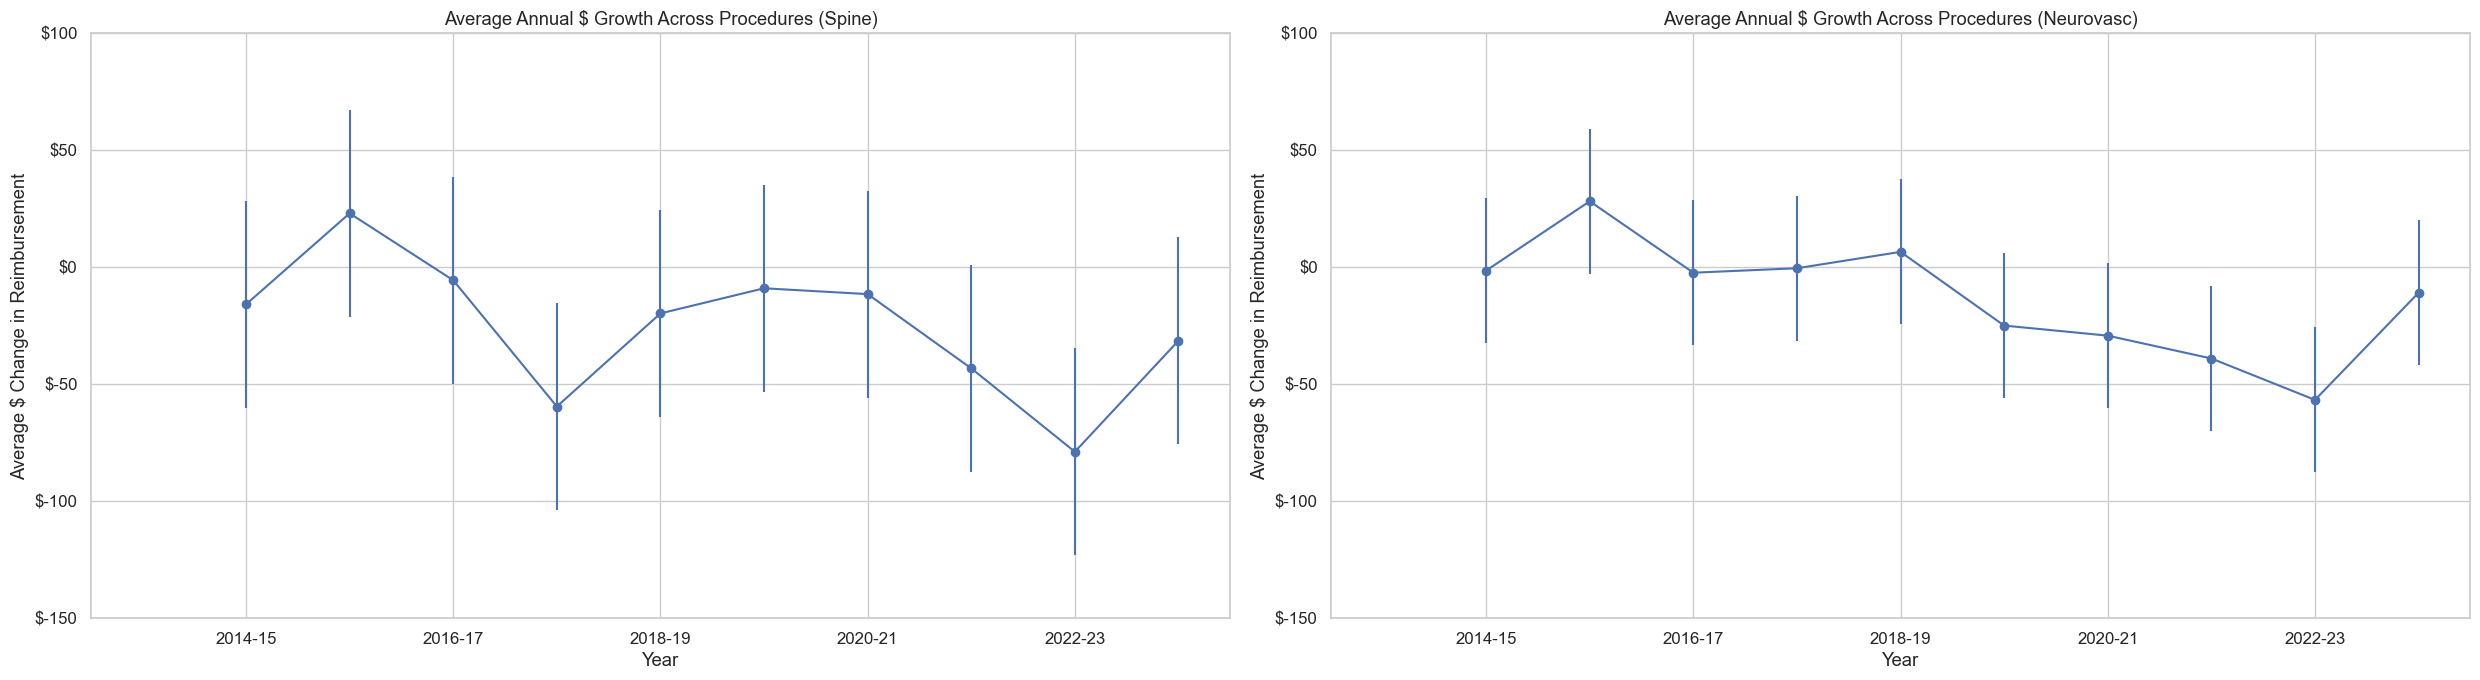

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7)) 

i = 0
for key, specialty in all_deltas.items():
    aagr = np.nanmean(np.array(specialty), axis=0)
    sem = np.nanstd(np.array(specialty), ddof=1) / np.sqrt(len(specialty))
    
    ci_lower = aagr - 1.96 * sem
    ci_upper = aagr + 1.96 * sem
    
    # Compute error bars from CI bounds
    yerr = [aagr - ci_lower, ci_upper - aagr]

    axs[i].errorbar(range(len(aagr)), aagr, yerr=yerr,  marker='o', markersize=6, linestyle='-')

    axs[i].set_xlabel("Year")
    axs[i].set_xticks([1, 3, 5, 7, 9])
    axs[i].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
    axs[i].set_ylabel("Average $ Change in Reimbursement")
    axs[i].set_ylim([-150, 100])
    axs[i].set_title(f"Average Annual $ Growth Across Procedures ({specialty_name[i]})")

    axs[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

    i += 1

plt.tight_layout()

## Total Payment

In [79]:
util_2023_2013_adj_spine['CI_lower_tot_pymt'] = util_2023_2013_adj_spine['Tot_Pymt_adj'] - 1.96 * util_2023_2013_adj_spine['Tot_Pymt_adj_sem']
util_2023_2013_adj_spine['CI_upper_tot_pymt'] = util_2023_2013_adj_spine['Tot_Pymt_adj'] + 1.96 * util_2023_2013_adj_spine['Tot_Pymt_adj_sem']

util_2023_2013_adj_neurovasc['CI_lower_tot_pymt'] = util_2023_2013_adj_neurovasc['Tot_Pymt_adj'] - 1.96 * util_2023_2013_adj_neurovasc['Tot_Pymt_adj_sem']
util_2023_2013_adj_neurovasc['CI_upper_tot_pymt'] = util_2023_2013_adj_neurovasc['Tot_Pymt_adj'] + 1.96 * util_2023_2013_adj_neurovasc['Tot_Pymt_adj_sem']

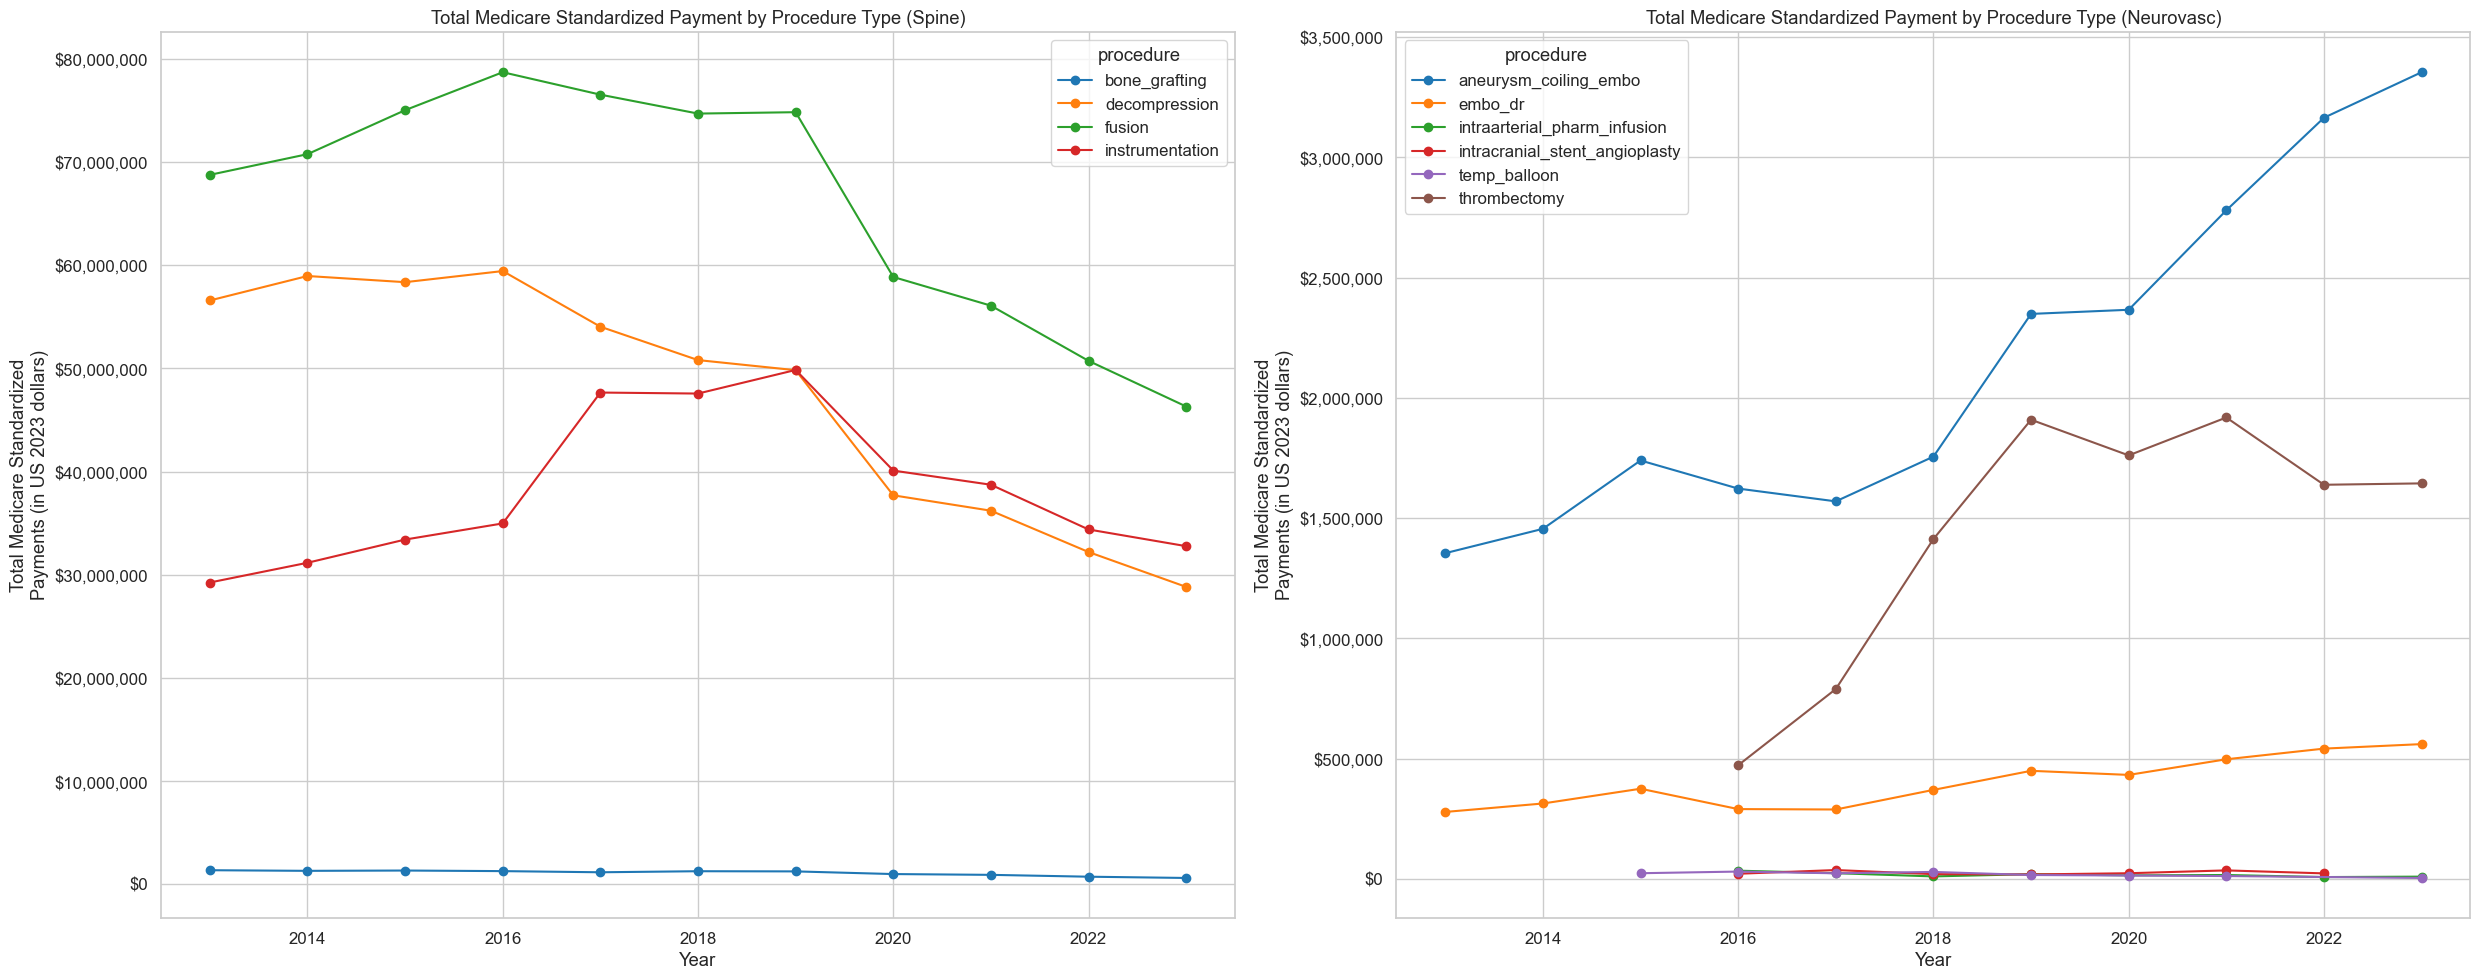

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10)) 

for i, specialty in enumerate([util_2023_2013_adj_spine, util_2023_2013_adj_neurovasc]):
    grouped = specialty.groupby(groupby_key)
    p_num = 0

    for label, df in grouped:
        # Sort by year to ensure proper line plotting
        df_sorted = df.sort_values('year')
        
        x = df_sorted['year']
        y = df_sorted['Sum_Pymt_adj']
    
        axs[i].plot(x, y, label=label, marker='o', markersize=6, linestyle='-', color=colors[p_num])
        p_num += 1
    
    axs[i].legend(title=groupby_key)
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Total Medicare Standardized\nPayments (in US 2023 dollars)")
    axs[i].set_title(f"Total Medicare Standardized Payment by Procedure Type ({specialty_name[i]})")
    
    axs[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.tight_layout()

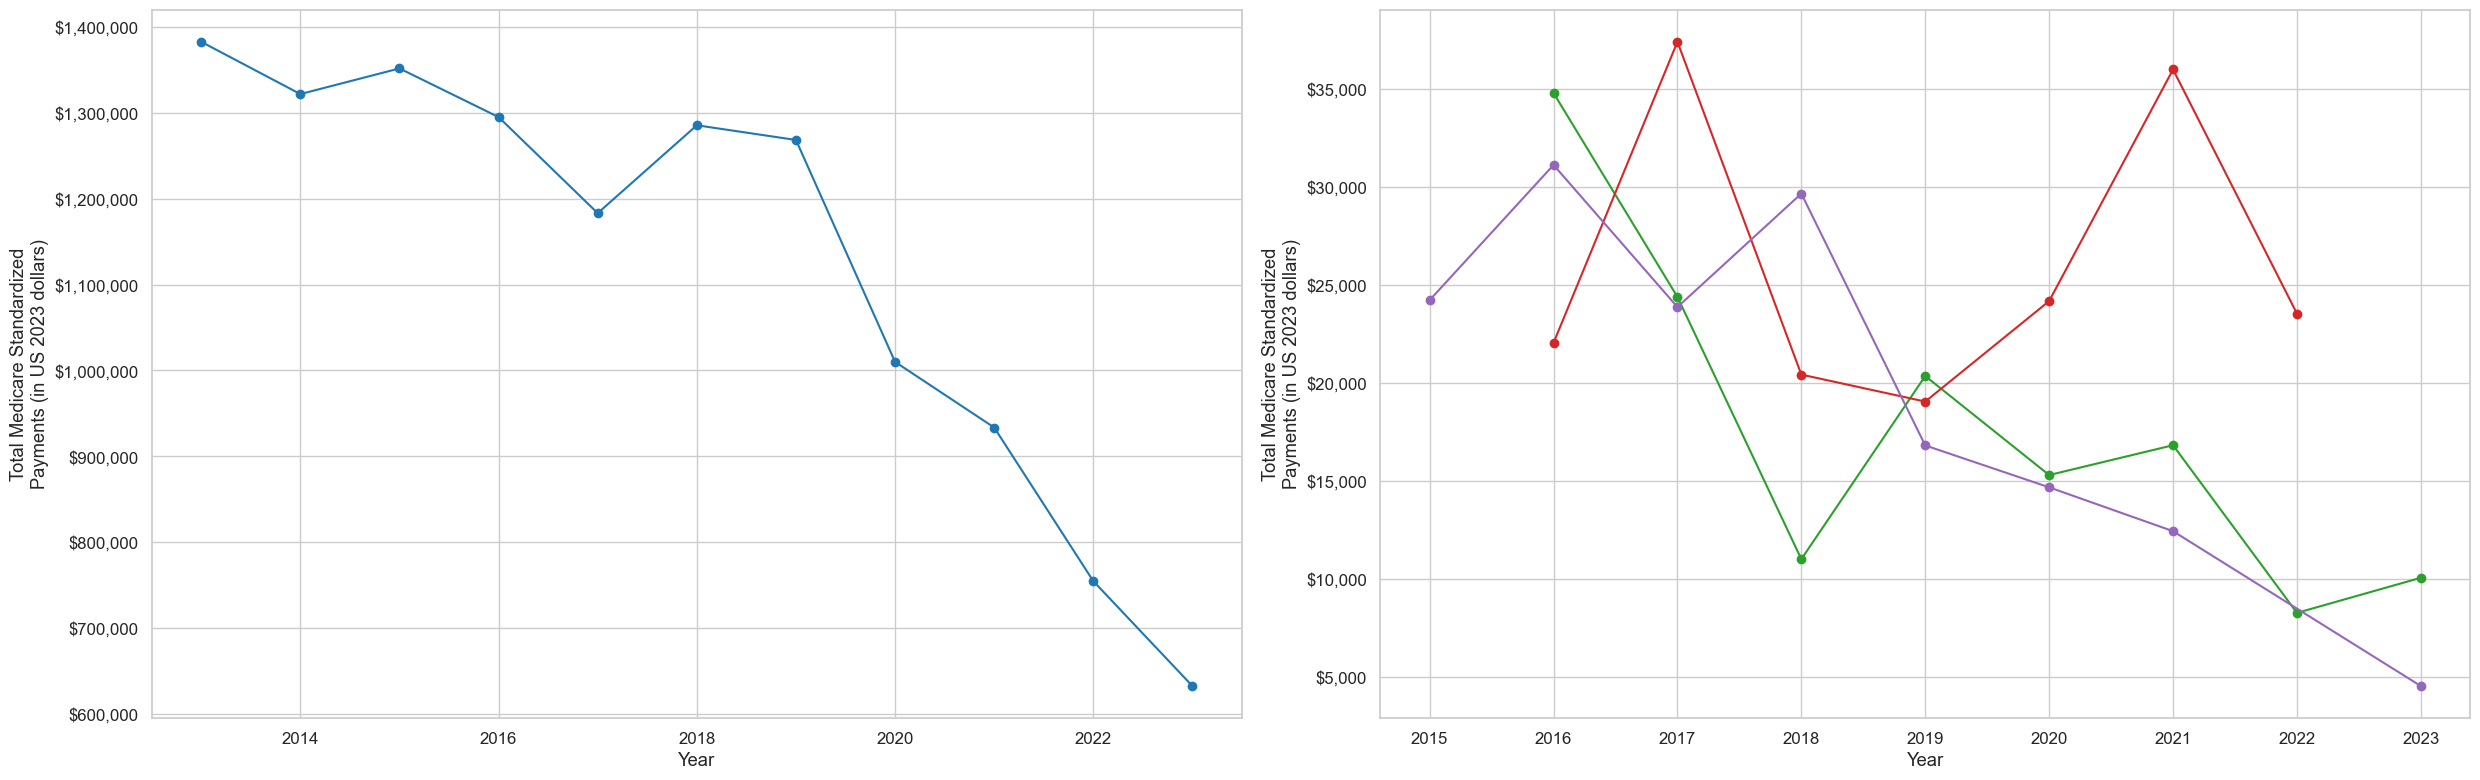

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8)) 
plot_inset = [
    ['fusion_cervical', 'bone_grafting', 'decompression_cervical', 'decompression_thoracic', 'fusion_thoracic', 'fusion_multiple_regions'],
    ["intracranial_stent_angioplasty", "intraarterial_pharm_infusion", "temp_balloon"]
]

for i, specialty in enumerate([util_2023_2013_adj_spine, util_2023_2013_adj_neurovasc]):
    grouped = specialty.groupby(groupby_key)
    p_num = 0
    
    for label, df in grouped:
        if label in plot_inset[i]:
            # Sort by year to ensure proper line plotting
            df_sorted = df.sort_values('year')
            
            x = df_sorted['year']
            y = df_sorted['Sum_Pymt_adj']
            axs[i].plot(x, y, label=label, marker='o', markersize=6, linestyle='-', color=colors[p_num])
        
        p_num += 1
    
    # axs[i].legend(title=groupby_key)
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Total Medicare Standardized\nPayments (in US 2023 dollars)")
    # axs[i].set_title(f"Total Medicare Standardized Payment by Procedure Type ({specialty_name[i]})")

    axs[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.tight_layout()

## Total Payment Growth Rate

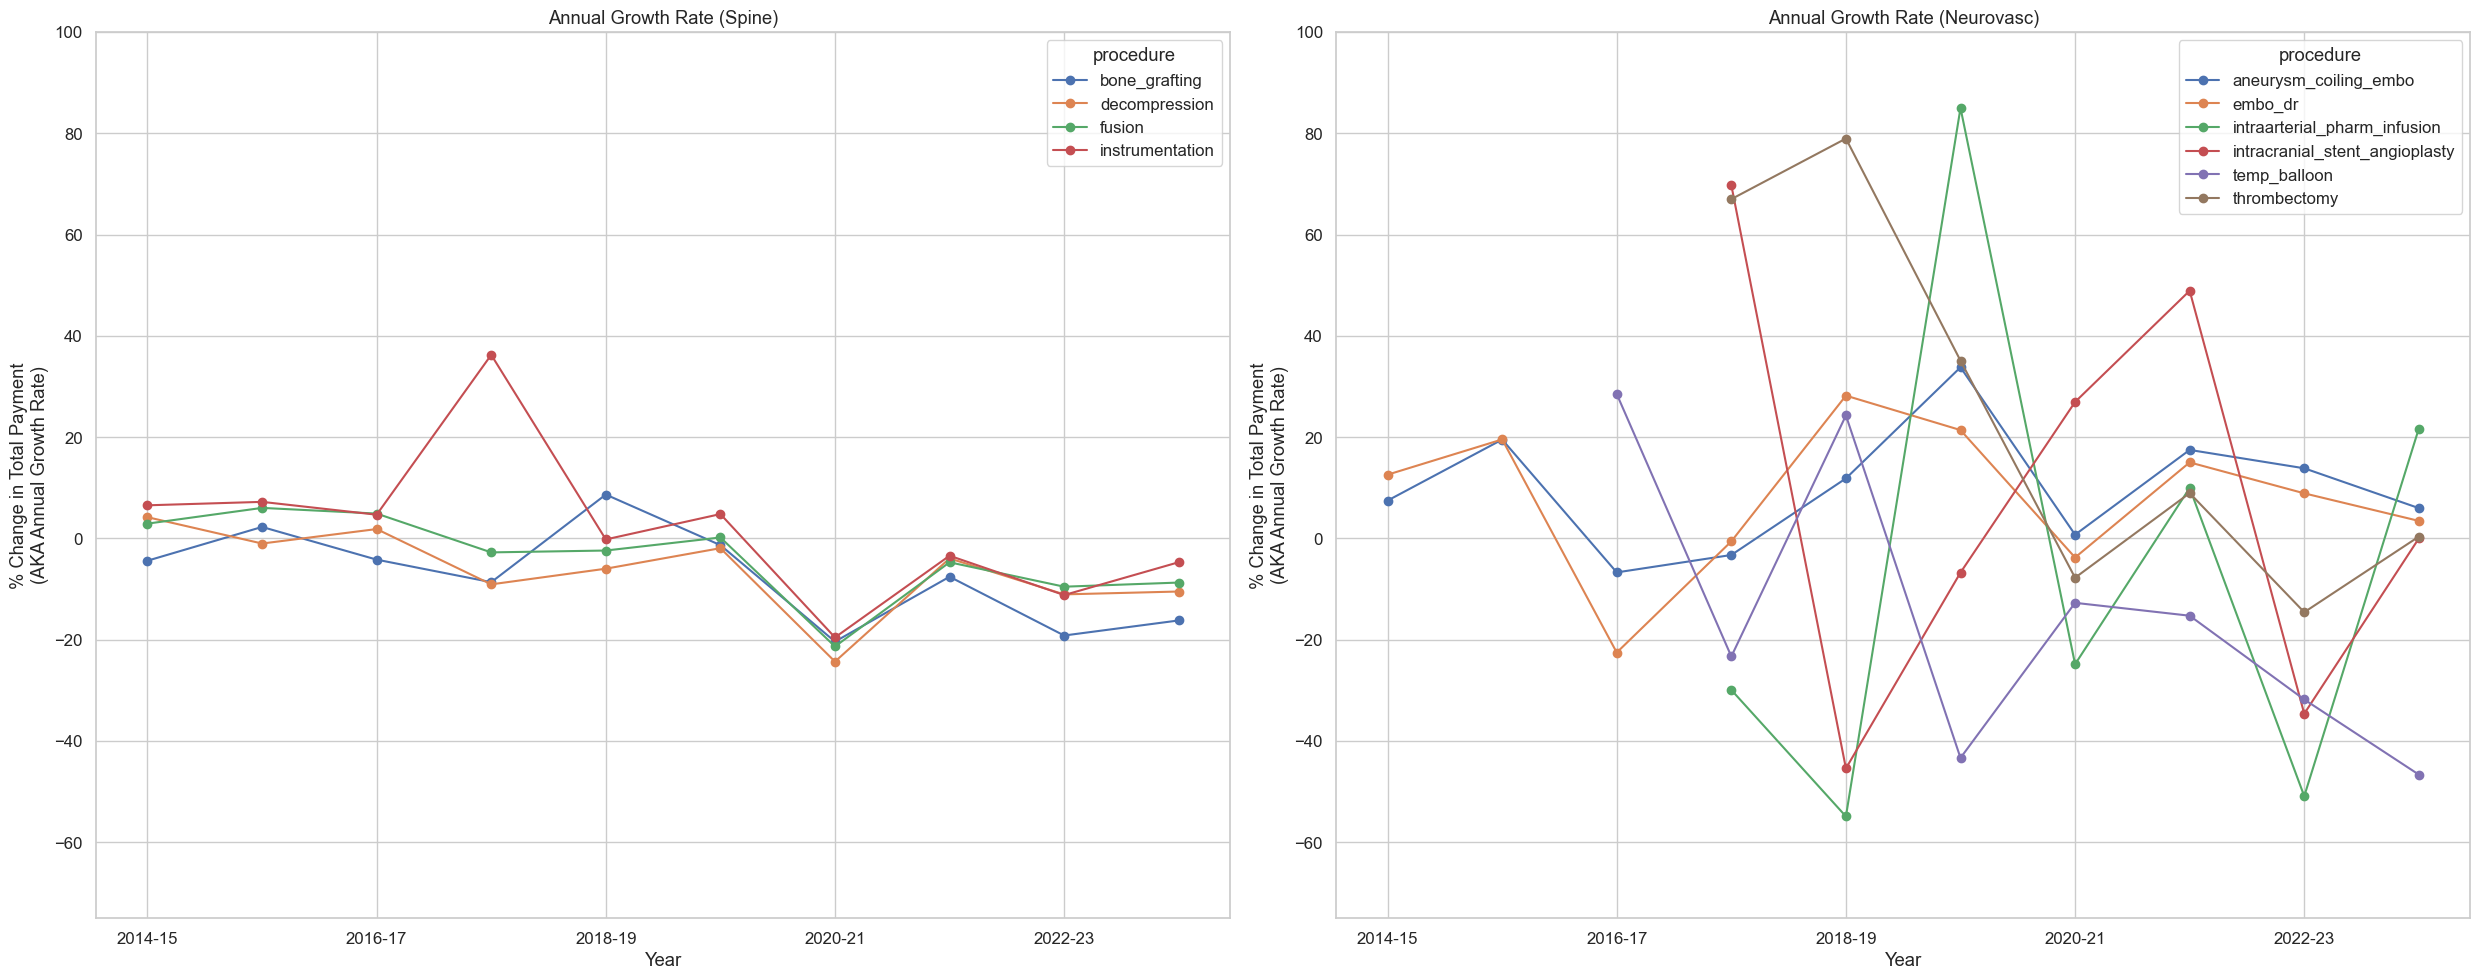

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10)) 

aagr = {'Spine': [], 'Neurovasc': []}
aagr_no_interp = {'Spine': [], 'Neurovasc': []}
all_deltas = {'Spine': [], 'Neurovasc': []}

for i, specialty in enumerate([util_2023_2013_adj_spine, util_2023_2013_adj_neurovasc]):
    grouped = specialty.groupby(groupby_key)
    for label, df in grouped:
        # Sort by year to ensure proper line plotting
        df_sorted = df.sort_values('year')
        
        x = df_sorted['year'].tolist()
        y = df_sorted['Sum_Pymt_adj'].tolist()
    
        pairs = {x[i]: item for i, item in enumerate(y)}
    
        x_new = list(range(2013, 2024))
    
        y_new = [pairs[year] if year in pairs else np.nan for year in x_new]
        delta = pd.Series(y_new).interpolate().pct_change().to_numpy() * 100

        axs[i].plot(range(len(delta)), delta, label=label, marker='o', markersize=6, linestyle='-')

        # Use this to compute AAGR per procedure later
        aagr[specialty_name[i]].append([label, np.nanmean(delta)])

        # Compute a version of AAGR without interpolation
        delta_no_interp = pd.Series(y_new).pct_change().to_numpy() * 100
        aagr_no_interp[specialty_name[i]].append([label, np.nanmean(delta_no_interp)])

        # Use this to plot average growth rate across procedures later
        all_deltas[specialty_name[i]].append(delta)

    axs[i].legend(title=groupby_key)
    axs[i].set_xlabel("Year")
    axs[i].set_xticks([1, 3, 5, 7, 9])
    axs[i].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
    axs[i].set_ylabel("% Change in Total Payment\n(AKA Annual Growth Rate)")
    axs[i].set_ylim([-75, 100])
    axs[i].set_title(f"Annual Growth Rate ({specialty_name[i]})")

plt.tight_layout()

In [85]:
pd.DataFrame(aagr['Spine'] + aagr['Neurovasc'], columns=['procedure', 'AAGR (%)']).sort_values(by=['AAGR (%)'])

,procedure,AAGR (%)
8,temp_balloon,-15.040037
0,bone_grafting,-7.098320
6,intraarterial_pharm_infusion,-6.273151
1,decompression,-6.178805
2,fusion,-3.544953
3,instrumentation,2.040695
5,embo_dr,8.216715
7,intracranial_stent_angioplasty,8.400442
4,aneurysm_coiling_embo,10.065279
9,thrombectomy,23.997230


In [86]:
stats.ttest_ind([x[1] for x in aagr['Spine']], [x[1] for x in aagr['Neurovasc']], alternative='less')

Ttest_indResult(statistic=-1.1975868540734522, pvalue=0.13267725010303003)

/var/folders/jv/hvl4bxhn45d10f4fq__lhlxm0000gn/T/ipykernel_51781/1072135359.py:5: RuntimeWarning: Mean of empty slice
  aagr = np.nanmean(np.array(specialty), axis=0)


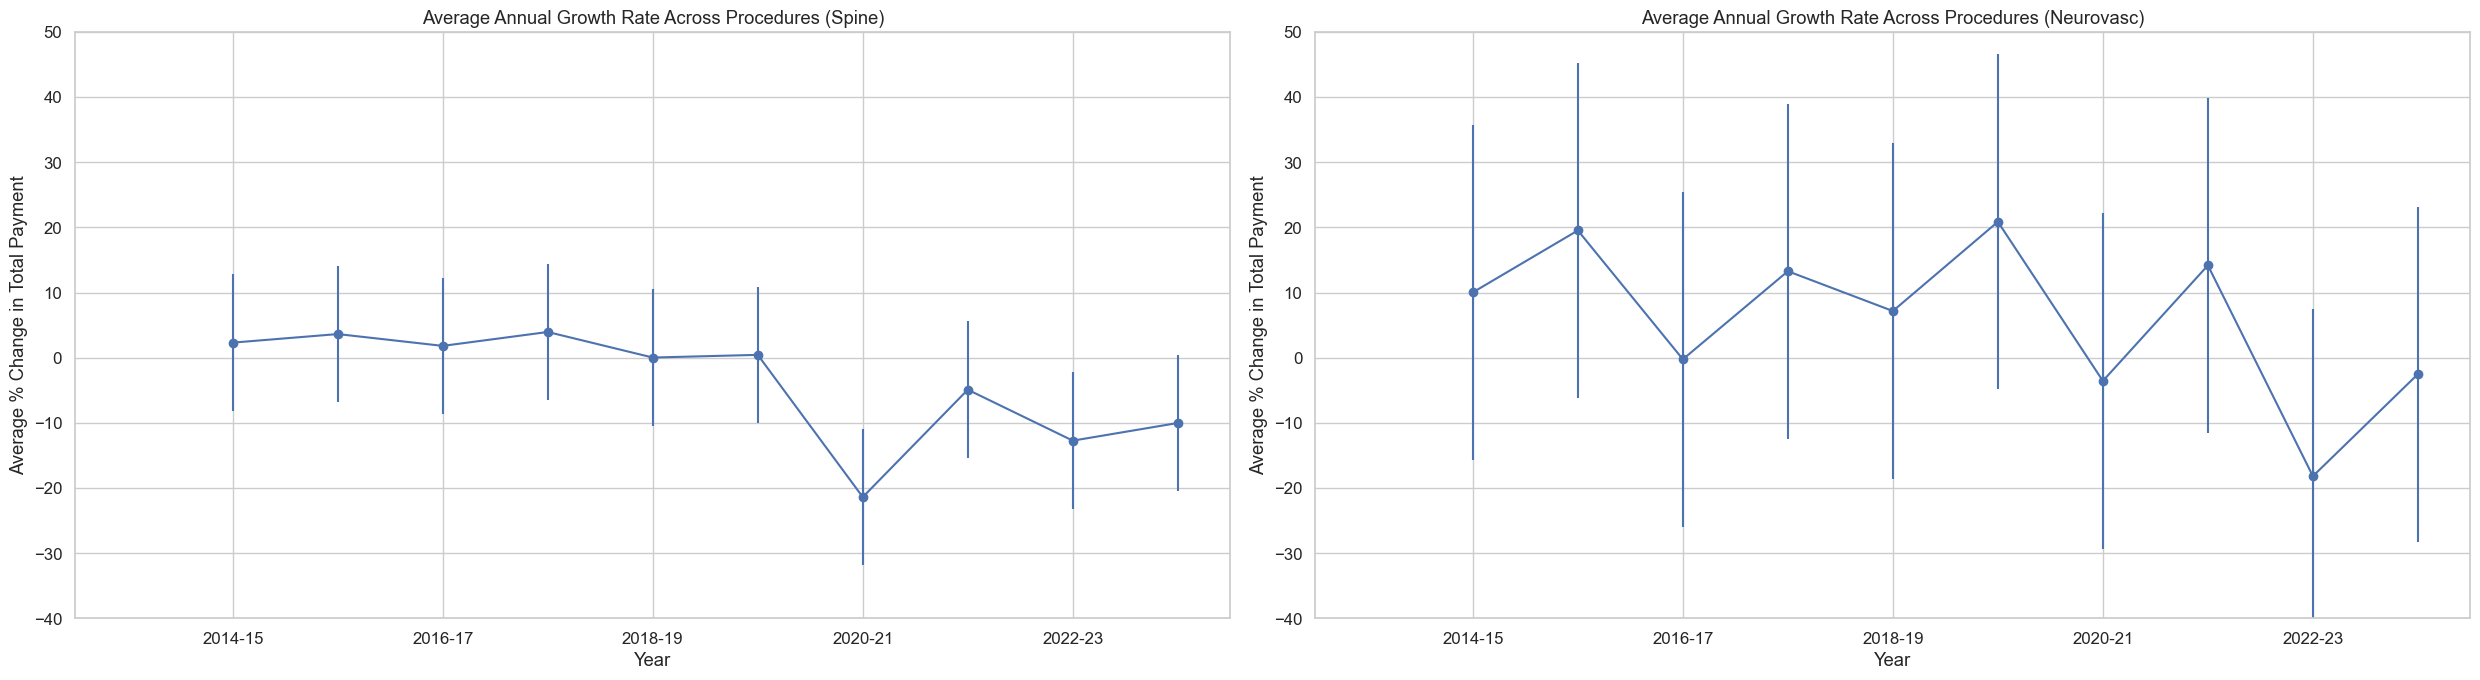

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7)) 

i = 0
for key, specialty in all_deltas.items():
    aagr = np.nanmean(np.array(specialty), axis=0)
    sem = np.nanstd(np.array(specialty), ddof=1) / np.sqrt(len(specialty))
    
    ci_lower = aagr - 1.96 * sem
    ci_upper = aagr + 1.96 * sem
    
    # Compute error bars from CI bounds
    yerr = [aagr - ci_lower, ci_upper - aagr]

    axs[i].errorbar(range(len(aagr)), aagr, yerr=yerr,  marker='o', markersize=6, linestyle='-')

    axs[i].set_xlabel("Year")
    axs[i].set_xticks([1, 3, 5, 7, 9])
    axs[i].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
    axs[i].set_ylabel("Average % Change in Total Payment")
    axs[i].set_ylim([-40, 50])
    axs[i].set_title(f"Average Annual Growth Rate Across Procedures ({specialty_name[i]})")

    i += 1

plt.tight_layout()

## Total Payment $ Growth

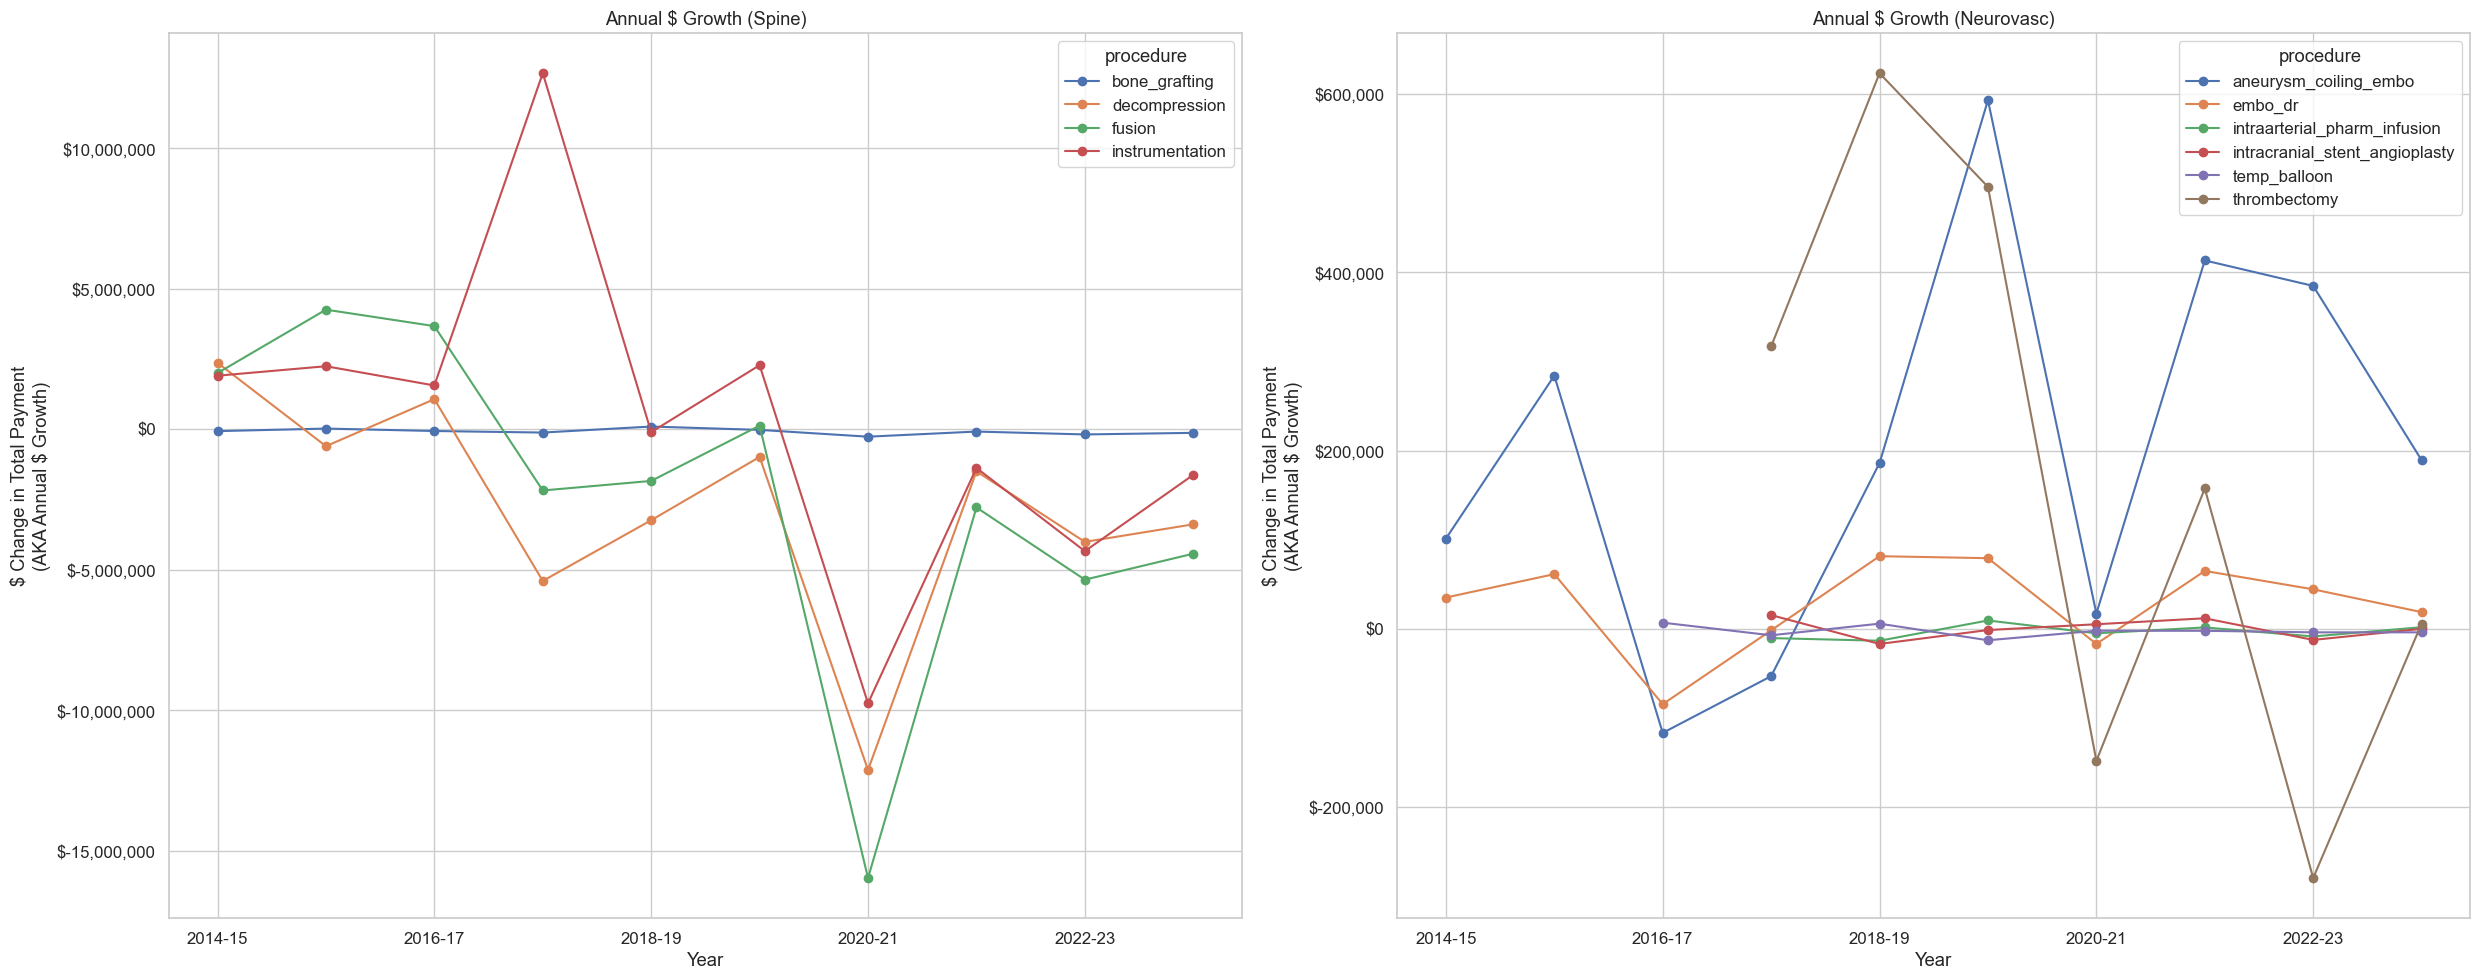

In [89]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10)) 

aagr = {'Spine': [], 'Neurovasc': []}
aagr_no_interp = {'Spine': [], 'Neurovasc': []}
all_deltas = {'Spine': [], 'Neurovasc': []}

for i, specialty in enumerate([util_2023_2013_adj_spine, util_2023_2013_adj_neurovasc]):
    grouped = specialty.groupby(groupby_key)
    for label, df in grouped:
        # Sort by year to ensure proper line plotting
        df_sorted = df.sort_values('year')
        
        x = df_sorted['year'].tolist()
        y = df_sorted['Sum_Pymt_adj'].tolist()
    
        pairs = {x[i]: item for i, item in enumerate(y)}
    
        x_new = list(range(2013, 2024))
    
        y_new = [pairs[year] if year in pairs else np.nan for year in x_new]
        delta = pd.Series(y_new).interpolate().diff().to_numpy()

        axs[i].plot(range(len(delta)), delta, label=label, marker='o', markersize=6, linestyle='-')

        # Use this to compute AAGR per procedure later
        aagr[specialty_name[i]].append([label, np.nanmean(delta)])

        # Compute a version of AAGR without interpolation
        delta_no_interp = pd.Series(y_new).pct_change().to_numpy() * 100
        aagr_no_interp[specialty_name[i]].append([label, np.nanmean(delta_no_interp)])

        # Use this to plot average growth rate across procedures later
        all_deltas[specialty_name[i]].append(delta)

    axs[i].legend(title=groupby_key)
    axs[i].set_xlabel("Year")
    axs[i].set_xticks([1, 3, 5, 7, 9])
    axs[i].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
    axs[i].set_ylabel("$ Change in Total Payment\n(AKA Annual $ Growth)")
    axs[i].set_title(f"Annual $ Growth ({specialty_name[i]})")

    axs[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.tight_layout()

In [90]:
temp = pd.DataFrame(aagr['Spine'] + aagr['Neurovasc'], columns=['procedure', 'Change in $']).sort_values(by=['Change in $'])
temp['Change in $'] = temp['Change in $'].apply(lambda x: f'${x:,.2f}'.format(x))
temp

,procedure,Change in $
1,decompression,"$-2,775,165.96"
2,fusion,"$-2,244,514.11"
0,bone_grafting,"$-75,063.52"
6,intraarterial_pharm_infusion,"$-3,533.72"
8,temp_balloon,"$-2,461.16"
7,intracranial_stent_angioplasty,$213.68
5,embo_dr,"$28,194.05"
9,thrombectomy,"$167,375.28"
4,aneurysm_coiling_embo,"$199,901.81"
3,instrumentation,"$352,129.64"


In [91]:
aagr_total_pymt = aagr

In [92]:
stats.ttest_ind([x[1] for x in aagr['Spine']], [x[1] for x in aagr['Neurovasc']], alternative='less')

Ttest_indResult(statistic=-2.029662019788918, pvalue=0.038448771999329404)

/var/folders/jv/hvl4bxhn45d10f4fq__lhlxm0000gn/T/ipykernel_51781/2937180287.py:5: RuntimeWarning: Mean of empty slice
  aagr = np.nanmean(np.array(specialty), axis=0)


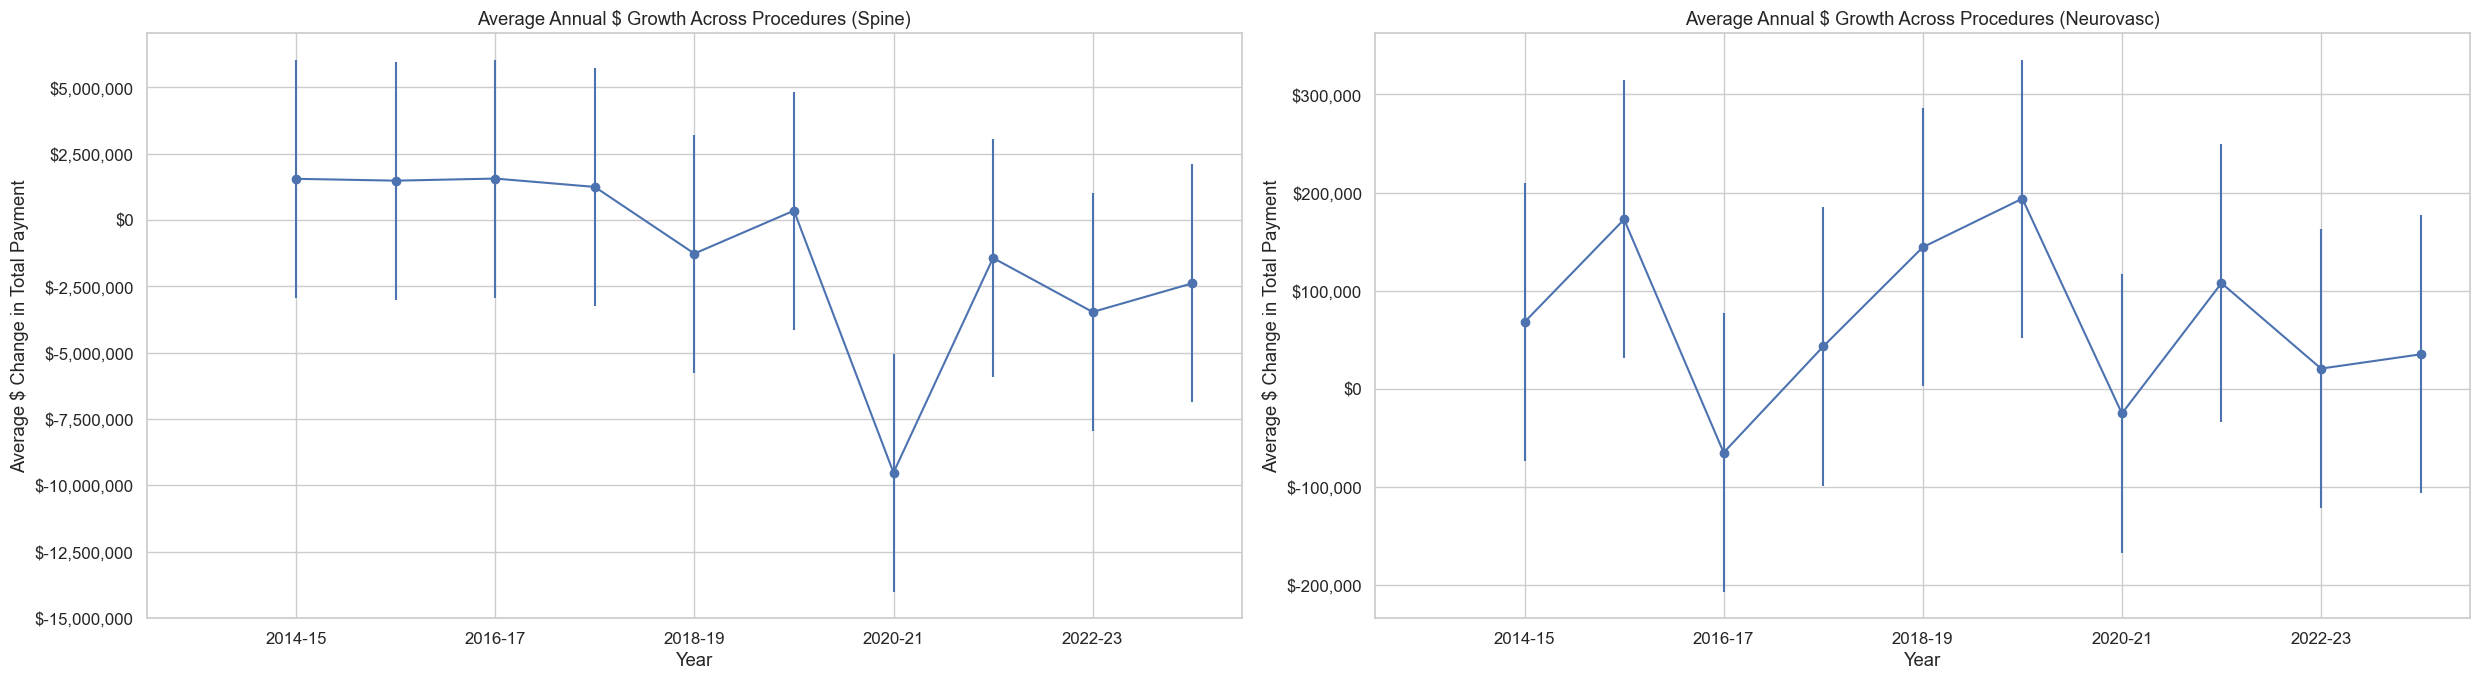

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7)) 

i = 0
for key, specialty in all_deltas.items():
    aagr = np.nanmean(np.array(specialty), axis=0)
    sem = np.nanstd(np.array(specialty), ddof=1) / np.sqrt(len(specialty))
    
    ci_lower = aagr - 1.96 * sem
    ci_upper = aagr + 1.96 * sem
    
    # Compute error bars from CI bounds
    yerr = [aagr - ci_lower, ci_upper - aagr]

    axs[i].errorbar(range(len(aagr)), aagr, yerr=yerr,  marker='o', markersize=6, linestyle='-')

    axs[i].set_xlabel("Year")
    axs[i].set_xticks([1, 3, 5, 7, 9])
    axs[i].set_xticklabels(['2014-15', '2016-17', '2018-19', '2020-21', '2022-23']),
    axs[i].set_ylabel("Average $ Change in Total Payment")
    # axs[i].set_ylim([-150, 100])
    axs[i].set_title(f"Average Annual $ Growth Across Procedures ({specialty_name[i]})")

    axs[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

    i += 1

plt.tight_layout()

# Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [18]:
def sklearn_linear_pvalues(model, X, y):
    """
    Compute OLS-style SEs, t-stats, and p-values for a fitted sklearn LinearRegression.
    Works only for unregularized linear models (no Ridge/Lasso).

    Parameters
    ----------
    model : sklearn.linear_model.LinearRegression (already .fit())
    X : pandas.DataFrame or numpy array (the SAME features the model was fit on)
    y : pandas Series or numpy array (target used for fitting)

    Returns
    -------
    pandas.DataFrame with columns: term, coef, se, t, p
    """
    X_arr = np.asarray(X, dtype=float)
    y_arr = np.asarray(y, dtype=float).ravel()

    # Build design matrix (add intercept column if model has an intercept)
    if getattr(model, "fit_intercept", False):
        X_design = np.column_stack([np.ones(X_arr.shape[0]), X_arr])
        coef = np.r_[model.intercept_, model.coef_]
        names = ["Intercept"] + (list(X.columns) if hasattr(X, "columns") else [f"x{i}" for i in range(X_arr.shape[1])])
    else:
        X_design = X_arr
        coef = np.asarray(model.coef_).ravel()
        names = list(X.columns) if hasattr(X, "columns") else [f"x{i}" for i in range(X_arr.shape[1])]

    # Predictions & residuals
    y_hat = X_design @ coef
    resid = y_arr - y_hat

    n, p = X_design.shape
    dof = n - p
    if dof <= 0:
        raise ValueError("Not enough degrees of freedom to compute standard errors (n <= p).")

    # Residual variance (sigma^2) and covariance of coefficients
    sigma2 = (resid @ resid) / dof
    # Use pinv to be robust to near-collinearity
    XtX_inv = np.linalg.pinv(X_design.T @ X_design)
    cov = sigma2 * XtX_inv

    se = np.sqrt(np.diag(cov))
    t_stats = coef / se
    p_vals = 2 * (1 - stats.t.cdf(np.abs(t_stats), dof))

    return pd.DataFrame({"term": names, "coef": coef, "se": se, "t": t_stats, "p": p_vals})


## Linear Regression by Procedure

In [19]:
spine_data_for_regression = util_2023_2013_adj_spine[['procedure', 'year', 'Avg_Price_per_service_adj', 'Sum_Pymt_adj']]
spine_data_for_regression = pd.get_dummies(spine_data_for_regression, columns=['procedure'])
spine_data_for_regression['specialty'] = 0

neurovasc_data_for_regression = util_2023_2013_adj_neurovasc[['procedure', 'year', 'Avg_Price_per_service_adj', 'Sum_Pymt_adj']]
neurovasc_data_for_regression = pd.get_dummies(neurovasc_data_for_regression, columns=['procedure'])
neurovasc_data_for_regression['specialty'] = 1

In [20]:
all_regression_data = pd.concat([spine_data_for_regression, neurovasc_data_for_regression]).reset_index(drop=True)

In [21]:
X = all_regression_data.drop(columns=['Sum_Pymt_adj']).dropna(subset=['Avg_Price_per_service_adj']).fillna(False)
y = all_regression_data['Sum_Pymt_adj']

In [22]:
model = LinearRegression()
model.fit(X, y)

# Coefficients & intercept
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

Intercept: 1134963106.454197
Coefficients: [-5.46398380e+05  9.42455567e+03 -3.22536682e+07  2.04722323e+07
  4.38157858e+07  3.12612057e+05 -3.23469621e+07 -7.86037300e+06
 -2.59758539e+05 -2.30455209e+06 -1.25218411e+07 -4.44053880e+06
 -4.95989853e+06]


In [23]:
feature_weights = []
for i, coef in enumerate(model.coef_):
    feature_weights.append([model.feature_names_in_[i], coef])

feature_weights = pd.DataFrame(feature_weights, columns=['Feature Name', 'Weight'])
feature_weights['Weight'] = feature_weights['Weight'].map('{:.2f}'.format)
feature_weights

,Feature Name,Weight
0,year,-546398.38
1,Avg_Price_per_service_adj,9424.56
2,procedure_bone_grafting,-32253668.18
3,procedure_decompression,20472232.35
4,procedure_fusion,43815785.84
5,procedure_instrumentation,312612.06
6,specialty,-32346962.06
7,procedure_aneurysm_coiling_embo,-7860373.00
8,procedure_embo_dr,-259758.54
9,procedure_intraarterial_pharm_infusion,-2304552.09


In [24]:
X = spine_data_for_regression.drop(columns=['Sum_Pymt_adj', 'specialty']).dropna(subset=['Avg_Price_per_service_adj']).fillna(False)
y = spine_data_for_regression['Sum_Pymt_adj']

model = LinearRegression()
model.fit(X, y)

# Coefficients & intercept
# print("Intercept:", model.intercept_)
# print("Coefficients:", model.coef_)

feature_weights = []
for i, coef in enumerate(model.coef_):
    feature_weights.append([model.feature_names_in_[i], coef])

feature_weights = pd.DataFrame(feature_weights, columns=['Feature Name', 'Weight'])
feature_weights['Weight'] = feature_weights['Weight'].map('{:.2f}'.format)
feature_weights

,Feature Name,Weight
0,year,-1178704.50
1,Avg_Price_per_service_adj,12457.04
2,procedure_bone_grafting,-38922570.32
3,procedure_decompression,12339786.16
4,procedure_fusion,34380735.34
5,procedure_instrumentation,-7797951.18


In [25]:
X = neurovasc_data_for_regression.drop(columns=['Sum_Pymt_adj', 'specialty']).dropna(subset=['Avg_Price_per_service_adj']).fillna(False)
y = neurovasc_data_for_regression['Sum_Pymt_adj']

model = LinearRegression()
model.fit(X, y)

# Coefficients & intercept
# print("Intercept:", model.intercept_)
# print("Coefficients:", model.coef_)

feature_weights = []
for i, coef in enumerate(model.coef_):
    feature_weights.append([model.feature_names_in_[i], coef])

feature_weights = pd.DataFrame(feature_weights, columns=['Feature Name', 'Weight'])
feature_weights['Weight'] = feature_weights['Weight'].map('{:.2f}'.format)
feature_weights

,Feature Name,Weight
0,year,48781.06
1,Avg_Price_per_service_adj,-1852.26
2,procedure_aneurysm_coiling_embo,2191001.20
3,procedure_embo_dr,-1381350.98
4,procedure_intraarterial_pharm_infusion,-1349368.91
5,procedure_intracranial_stent_angioplasty,639519.29
6,procedure_temp_balloon,-978407.34
7,procedure_thrombectomy,878606.73


## Linear Regression by CPT Code

In [12]:
# Group by procedure and year, and summarize
cpt_2023_2013_adj_spine = (
    spine_data
    .groupby(['HCPCS_Cd', 'year'], as_index=False)
    .agg(
        Sum_Utilization=('Tot_Srvcs', 'sum'),
        Sum_Spend=('Tot_Srvcs_Spend', 'sum'),
        Sum_Pymt=('Tot_Pymt', 'sum'),
        Sum_Spend_adj=('Tot_Srvcs_Spend_adj', 'sum'),
        Sum_Pymt_adj=('Tot_Pymt_adj', 'sum'),
        Avg_Price_per_service_adj=('Avg_Mdcr_Stdzd_Amt_adj', 'mean'),
        Avg_Price_per_service_adj_sem=('Avg_Mdcr_Stdzd_Amt_adj', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
        Tot_Pymt_adj=('Tot_Pymt_adj', 'mean'), # Tot_Pymt is actually Avg_Pymt, bad naming
        Tot_Pymt_adj_sem=('Tot_Pymt_adj', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
        Sum_Provider=('Rndrng_NPI', lambda x: x.nunique())
    )
)

cpt_2023_2013_adj_neurovasc = (
    neurovasc_data
    .groupby(['HCPCS_Cd', 'year'], as_index=False)
    .agg(
        Sum_Utilization=('Tot_Srvcs', 'sum'),
        Sum_Spend=('Tot_Srvcs_Spend', 'sum'),
        Sum_Pymt=('Tot_Pymt', 'sum'),
        Sum_Spend_adj=('Tot_Srvcs_Spend_adj', 'sum'),
        Sum_Pymt_adj=('Tot_Pymt_adj', 'sum'),
        Avg_Price_per_service_adj=('Avg_Mdcr_Stdzd_Amt_adj', 'mean'),
        Avg_Price_per_service_adj_sem=('Avg_Mdcr_Stdzd_Amt_adj', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
        Tot_Pymt_adj=('Tot_Pymt_adj', 'mean'), # Tot_Pymt is actually Avg_Pymt, bad naming
        Tot_Pymt_adj_sem=('Tot_Pymt_adj', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
        Sum_Provider=('Rndrng_NPI', lambda x: x.nunique()))
)

In [14]:
spine_data_for_regression = util_2023_2013_adj_spine[['HCPCS_Cd', 'year', 'Avg_Price_per_service_adj', 'Sum_Pymt_adj']]
spine_data_for_regression = pd.get_dummies(spine_data_for_regression, columns=['HCPCS_Cd'])
spine_data_for_regression['specialty'] = 0

neurovasc_data_for_regression = util_2023_2013_adj_neurovasc[['HCPCS_Cd', 'year', 'Avg_Price_per_service_adj', 'Sum_Pymt_adj']]
neurovasc_data_for_regression = pd.get_dummies(neurovasc_data_for_regression, columns=['HCPCS_Cd'])
neurovasc_data_for_regression['specialty'] = 1

In [15]:
all_regression_data = pd.concat([spine_data_for_regression, neurovasc_data_for_regression]).reset_index(drop=True)

In [26]:
X = all_regression_data.drop(columns=['Sum_Pymt_adj']).dropna(subset=['Avg_Price_per_service_adj']).fillna(False)
y = all_regression_data['Sum_Pymt_adj']

model = LinearRegression()
model.fit(X, y)

# Coefficients & intercept
# print("Intercept:", model.intercept_)
# print("Coefficients:", model.coef_)

feature_weights = []
for i, coef in enumerate(model.coef_):
    feature_weights.append([model.feature_names_in_[i], coef])

feature_weights = pd.DataFrame(feature_weights, columns=['Feature Name', 'Weight'])
feature_weights['Weight'] = feature_weights['Weight'].map('{:.2f}'.format)
feature_weights.tail(n=24)

/var/folders/jv/hvl4bxhn45d10f4fq__lhlxm0000gn/T/ipykernel_61793/4058833068.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = all_regression_data.drop(columns=['Sum_Pymt_adj']).dropna(subset=['Avg_Price_per_service_adj']).fillna(False)


,Feature Name,Weight
51,HCPCS_Cd_63046,-2944440.23
52,HCPCS_Cd_63047,33054976.81
53,HCPCS_Cd_63048,8505376.63
54,HCPCS_Cd_63051,-3998983.39
55,HCPCS_Cd_63052,374208.07
56,HCPCS_Cd_63053,-998109.01
57,HCPCS_Cd_63075,-3122910.95
58,HCPCS_Cd_63076,-2377345.45
59,HCPCS_Cd_63081,-2972975.16
60,HCPCS_Cd_63082,-1937469.26


In [29]:
X = spine_data_for_regression.drop(columns=['Sum_Pymt_adj', 'specialty']).dropna(subset=['Avg_Price_per_service_adj']).fillna(False)
y = spine_data_for_regression['Sum_Pymt_adj']

model = LinearRegression()
model.fit(X, y)

# Coefficients & intercept
# print("Intercept:", model.intercept_)
# print("Coefficients:", model.coef_)

feature_weights = []
for i, coef in enumerate(model.coef_):
    feature_weights.append([model.feature_names_in_[i], coef])

feature_weights = pd.DataFrame(feature_weights, columns=['Feature Name', 'Weight'])
feature_weights['Weight'] = feature_weights['Weight'].map('{:.2f}'.format)
feature_weights.tail(n=32)

,Feature Name,Weight
32,HCPCS_Cd_22846,-2209193.79
33,HCPCS_Cd_22849,-2619013.98
34,HCPCS_Cd_22853,11674646.33
35,HCPCS_Cd_22854,-1632762.60
36,HCPCS_Cd_22859,-1831755.68
37,HCPCS_Cd_62380,-3415407.90
38,HCPCS_Cd_63001,-2764751.31
39,HCPCS_Cd_63003,-3726795.97
40,HCPCS_Cd_63005,-2956035.85
41,HCPCS_Cd_63015,-3464626.03


In [20]:
X = neurovasc_data_for_regression.drop(columns=['Sum_Pymt_adj', 'specialty']).dropna(subset=['Avg_Price_per_service_adj']).fillna(False)
y = neurovasc_data_for_regression['Sum_Pymt_adj']

model = LinearRegression()
model.fit(X, y)

# Coefficients & intercept
# print("Intercept:", model.intercept_)
# print("Coefficients:", model.coef_)

feature_weights = []
for i, coef in enumerate(model.coef_):
    feature_weights.append([model.feature_names_in_[i], coef])

feature_weights = pd.DataFrame(feature_weights, columns=['Feature Name', 'Weight'])
feature_weights['Weight'] = feature_weights['Weight'].map('{:.2f}'.format)
feature_weights

,Feature Name,Weight
0,year,27673.58
1,Avg_Price_per_service_adj,-2006.45
2,HCPCS_Cd_37184,-534487.93
3,HCPCS_Cd_37185,-1111665.26
4,HCPCS_Cd_61623,-487629.25
5,HCPCS_Cd_61624,2747615.54
6,HCPCS_Cd_61626,-104963.65
7,HCPCS_Cd_61635,1273883.33
8,HCPCS_Cd_61645,1427467.08
9,HCPCS_Cd_61650,-867278.90


## Linear Regression by Specialty

In [13]:
spine_data_for_regression = util_2023_2013_adj_spine[['year', 'Avg_Price_per_service_adj', 'Sum_Pymt_adj']].copy()
spine_data_for_regression['is_spine'] = 1
spine_data_for_regression['specialty'] = 0

neurovasc_data_for_regression = util_2023_2013_adj_neurovasc[['year', 'Avg_Price_per_service_adj', 'Sum_Pymt_adj']].copy()
neurovasc_data_for_regression['is_neurovasc'] = 1
neurovasc_data_for_regression['specialty'] = 1

In [14]:
all_regression_data = pd.concat([spine_data_for_regression, neurovasc_data_for_regression]).reset_index(drop=True).fillna(0)

In [15]:
X = all_regression_data.drop(columns=['Sum_Pymt_adj']).dropna(subset=['Avg_Price_per_service_adj']).fillna(False)
X = sm.add_constant(X)
y = all_regression_data['Sum_Pymt_adj']

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Sum_Pymt_adj   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     17.57
Date:                Sat, 16 Aug 2025   Prob (F-statistic):           6.37e-10
Time:                        09:30:46   Log-Likelihood:                -2973.4
No. Observations:                 166   AIC:                             5955.
Df Residuals:                     162   BIC:                             5967.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [20]:
X = all_regression_data.drop(columns=['Sum_Pymt_adj', 'is_spine', 'is_neurovasc']).dropna(subset=['Avg_Price_per_service_adj']).fillna(0)
y = all_regression_data['Sum_Pymt_adj']

model = LinearRegression().fit(X, y)
summary = sklearn_linear_pvalues(model, X, y)

# Coefficients & intercept
# print("Intercept:", model.intercept_)
# print("Coefficients:", model.coef_)

feature_weights = []
for i, coef in enumerate(model.coef_):
    feature_weights.append([model.feature_names_in_[i], coef])

feature_weights = pd.DataFrame(feature_weights, columns=['Feature Name', 'Weight'])
feature_weights['Weight'] = feature_weights['Weight'].map('{:.2f}'.format)
feature_weights.tail(n=24)

,Feature Name,Weight
0,year,-287021.22
1,Avg_Price_per_service_adj,4458.04
2,specialty,-16380083.20


In [21]:
summary['p'] =  summary['p'].apply(lambda x: f'{x:,.12f}'.format(x)) 
summary

,term,coef,se,t,p
0,Intercept,5.935827e+08,7.651933e+08,0.775729,0.439039918296
1,year,-2.870212e+05,3.790244e+05,-0.757263,0.449992234032
2,Avg_Price_per_service_adj,4.458045e+03,2.604608e+03,1.711599,0.088884319124
3,specialty,-1.638008e+07,2.480224e+06,-6.604277,0.000000000546


## Linear Regression by $ in Total Payment

In [110]:
specialty_name = ["Spine", "Neurovasc"]
aagr = {'Spine': {}, 'Neurovasc': {}}
aagr_no_interp = {'Spine': {}, 'Neurovasc': {}}

x_years = list(range(2013, 2024)) # list(range(2013, 2024))

for i, specialty in enumerate([util_2023_2013_adj_spine, util_2023_2013_adj_neurovasc]):
    grouped = specialty.groupby(groupby_key)
    for label, df in grouped:
        # Sort by year to ensure proper line plotting
        df_sorted = df.sort_values('year')
        
        x = df_sorted['year'].tolist()
        y = df_sorted['Sum_Pymt_adj'].tolist()
    
        pairs = {x[k]: item for k, item in enumerate(y)}
        x_new = x_years
    
        y_new = [pairs[year] if year in pairs else np.nan for year in x_new]
        delta = pd.Series(y_new).interpolate().diff().to_numpy()
        
        # Use this to compute AAGR per procedure later
        aagr[specialty_name[i]][label] = delta

        # Compute a version of AAGR without interpolation
        delta_no_interp = pd.Series(y_new).pct_change().to_numpy() * 100
        aagr_no_interp[specialty_name[i]][label] = delta_no_interp

In [111]:
aagr_for_df = []
years = x_years
for specialty, data in aagr.items():
    for proc, delta in data.items():
        aagr_for_df.extend([[years[i], proc, delta[i]] for i in range(len(delta))])

In [112]:
aagr_df = pd.DataFrame(aagr_for_df, columns=["year", "procedure", "sum_pymt_change"])

In [113]:
aagr_df_spine = util_2023_2013_adj_spine.merge(aagr_df, on=["procedure", "year"])
aagr_df_neurovasc = util_2023_2013_adj_neurovasc.merge(aagr_df, on=["procedure", "year"])

In [114]:
spine_data_for_regression = aagr_df_spine[['procedure', 'year', 'Avg_Price_per_service_adj', 'sum_pymt_change']]
spine_data_for_regression['specialty'] = 0

neurovasc_data_for_regression = aagr_df_neurovasc[['procedure', 'year', 'Avg_Price_per_service_adj', 'sum_pymt_change']]
neurovasc_data_for_regression['specialty'] = 1

/var/folders/jv/hvl4bxhn45d10f4fq__lhlxm0000gn/T/ipykernel_51781/870439428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spine_data_for_regression['specialty'] = 0
/var/folders/jv/hvl4bxhn45d10f4fq__lhlxm0000gn/T/ipykernel_51781/870439428.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neurovasc_data_for_regression['specialty'] = 1


In [115]:
all_regression_data = pd.concat([spine_data_for_regression, neurovasc_data_for_regression]).reset_index(drop=True).fillna(0)

In [116]:
X = all_regression_data.drop(columns=['sum_pymt_change', 'procedure']).dropna(subset=['Avg_Price_per_service_adj']).fillna(False)
X = sm.add_constant(X)
y = all_regression_data['sum_pymt_change']

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        sum_pymt_change   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     5.063
Date:                Wed, 27 Aug 2025   Prob (F-statistic):            0.00272
Time:                        11:31:09   Log-Likelihood:                -1576.0
No. Observations:                  97   AIC:                             3160.
Df Residuals:                      93   BIC:                             3170.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [117]:
X = all_regression_data.drop(columns=['sum_pymt_change', 'procedure']).dropna(subset=['Avg_Price_per_service_adj']).fillna(False)
y = all_regression_data['sum_pymt_change']

model = LinearRegression().fit(X, y)
summary = sklearn_linear_pvalues(model, X, y)

# Coefficients & intercept
# print("Intercept:", model.intercept_)
# print("Coefficients:", model.coef_)

feature_weights = []
for i, coef in enumerate(model.coef_):
    feature_weights.append([model.feature_names_in_[i], coef])

summary['p'] =  summary['p'].apply(lambda x: f'{x:,.10f}'.format(x)) 
summary[['term', 'coef', 'p']]

,term,coef,p
0,Intercept,6.406548e+08,0.0016169305
1,year,-3.177271e+05,0.0015985182
2,Avg_Price_per_service_adj,-8.013933e+02,0.2228780018
3,specialty,1.329824e+06,0.0235739926
